# Loading all CSV's with news scrapped data 

In [67]:
# load all csv's from the folder '/Users/shreyashgupta/Library/CloudStorage/OneDrive-UniversityofArkansas/General - FINN 5323 Group Project/News data' and add them as one dataframe because they will have the same columns.
import os
import pandas as pd

path = '/Users/shreyashgupta/Library/Mobile Documents/com~apple~CloudDocs/Github Projects/News_sentiment_correlation_project/News data'
files = os.listdir(path)
news_unclean_df = pd.DataFrame()
for file in files:
    if file.endswith('.csv'):
        news_unclean_df = pd.concat([news_unclean_df, pd.read_csv(path + '/' + file, encoding='latin-1')], ignore_index=True)

In [68]:
news_unclean_df.shape

(339, 6)

# Getting all stock Tickers
-----

In [69]:
# import Nasdaq Screener.csv from '/Users/shreyashgupta/Library/CloudStorage/OneDrive-UniversityofArkansas/General - FINN 5323 Group Project'
nasdaq = pd.read_csv('/Users/shreyashgupta/Library/Mobile Documents/com~apple~CloudDocs/Github Projects/News_sentiment_correlation_project/Nasdaq Screener.csv')

# drop all columns from the nasdaq dataframe except 'Symbol'.
nasdaq.drop(nasdaq.columns.difference(['Symbol']), axis=1, inplace=True)

# Cleaning news_unclean_df for Tickers

In [70]:
# merge the Ticker and Tickers column so if both have values then both the values get added up into the new column with just a space. If one of them is empty then the other one is added as it is.
news_unclean_df['Ticker'] = news_unclean_df['Ticker'].fillna('') + ' ' + news_unclean_df['Tickers'].fillna('')

# drop the Tickers column as we have merged it with the Ticker column.
news_unclean_df.drop('Tickers', axis=1, inplace=True)

# drop if there are null values in the Title, Date, Content columns.
news_unclean_df.dropna(subset=['Title', 'Date', 'Content'], inplace=True)

# In the Ticker column, if there is a word that is all capital letters and is of length 1-5 then it is considered as a ticker symbol. So, we extract all the words that are of length 1-5 and are all capital letters. If there are multiple words that are of length 1-5 and are all capital letters then we keep all of them just separated by a space.
news_unclean_df['Ticker'] = news_unclean_df['Ticker'].str.findall(r'\b[A-Z]{1,5}\b').str.join(', ')

# Create a new column called 'Ticker_extracted' which will look at the 'Content' column and if there is a word that is all capital letters and is of length 1-5 then it is considered as a ticker symbol. So, we extract all the words that are of length 1-5 and are all capital letters. If there are multiple words that are of length 1-5 and are all capital letters then we keep all of them just separated by a comma.
news_unclean_df['Ticker_extracted'] = news_unclean_df['Content'].str.findall(r'\b[A-Z]{1,5}\b').str.join(', ')

# merge the Ticker and Ticker_extracted column so if both have values then both the values get added up into the new column with just a comma. If one of them is empty then the other one is added as it is. Then we drop the Ticker and Ticker_extracted columns.
news_unclean_df['Ticker'] = news_unclean_df['Ticker'].fillna('') + ', ' + news_unclean_df['Ticker_extracted'].fillna('')
news_unclean_df.drop(['Ticker_extracted'], axis=1, inplace=True)

# Now for each value in the 'Ticker' column we check if it is present in the 'Symbol' column of the nasdaq dataframe. If it is present then we keep it as it is. If it is not present then we remove it. If there are multiple values then we keep all of them just separated by a comma. If a value does not match with any value in the 'Symbol' column then we remove it.
news_unclean_df['Ticker'] = news_unclean_df['Ticker'].str.split(', ').apply(lambda x: ', '.join([i for i in x if i in nasdaq['Symbol'].values]))

# if there are duplicate values in the 'Ticker' column within the same value so if the value is 'AAPL, AAPL' then we remove the duplicate values and only keep one of them.
news_unclean_df['Ticker'] = news_unclean_df['Ticker'].str.split(', ').apply(lambda x: ', '.join(list(set(x))))

# Adding sentiment scores to 'news_unclean_df'

In [71]:
import numpy as np
import pandas as pd
from dateutil import parser
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize the SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Function to classify sentiment based on compound score
def classify_sentiment(score):
    if score > 0:
        return 1
    elif score < 0:
        return -1
    else:
        return 0

# Calculate sentiment scores for 'Title' and 'Content'
news_unclean_df['Title_Sentiment'] = news_unclean_df['Title'].apply(lambda x: classify_sentiment(analyzer.polarity_scores(x)['compound']))
news_unclean_df['Content_Sentiment'] = news_unclean_df['Content'].apply(lambda x: classify_sentiment(analyzer.polarity_scores(x)['compound']))

# Calculate the weighted sum
news_unclean_df['Final_Sentiment'] = (news_unclean_df['Title_Sentiment'] * 0.75) + (news_unclean_df['Content_Sentiment'] * 0.25)

# Discretize the 'Final_Sentiment' values to -1, 0, or 1
bins = [-np.inf, -0.5, 0.5, np.inf]
labels = [-1, 0, 1]
news_unclean_df['Final_Sentiment'] = pd.cut(news_unclean_df['Final_Sentiment'], bins=bins, labels=labels, include_lowest=True)

# set the index of news_unclean_df to 'Date' column.
news_unclean_df.set_index('Date', inplace=True)

In [72]:
test = news_unclean_df.copy()

# Cleaning Date index

In [73]:
# duplicate date index to a coulmn and call that new column 'Date_test'.
test['Date_test'] = test.index

# for the Date_test column remove the first 5 characters
test['Date_test'] = test['Date_test'].str[5:]

# for Date_test column remove the last 13 characters
test['Date_test'] = test['Date_test'].str[:-13]

# remove null value rows is it is null in Date_test column.
test = test.dropna(subset=['Date_test'])

# Assuming df is your DataFrame and 'Date_test' is the column you want to modify.
test['Date_test'] = test['Date_test'].replace('April', 'Apr', regex=True)

test['Date_test'] = test['Date_test'].replace('Apr', 'April', regex=True)

# if there is a , at the end of any value then remove it in the Date_test column.
test['Date_test'] = test['Date_test'].str.rstrip(',')

# Assuming 'test' is your DataFrame and 'Date_test' is the column with dates in 'April 21, 2024' format
test['Date_test'] = pd.to_datetime(test['Date_test']).dt.strftime('%m/%d/%Y')

# # set the Date_test as the index of the dataframe.
test.set_index('Date_test', inplace=True)

# rename the index to say 'Date'
test.index.rename('Date', inplace=True)

# set index as datetime
test.index = pd.to_datetime(test.index)

clean_news_df = test.copy()

# All the unique tickers from the news using - 'ticker_df'

In [74]:
# Create a new dataframe that has all the unique values from the 'Ticker' column. Each value is separated by a comma.
ticker_df = pd.DataFrame(clean_news_df['Ticker'].str.split(', ').explode().unique(), columns=['Ticker'])

# filter ticker_df so it only keep the following values: 'AAPL', 'AMZN', 'GOOGL', 'MSFT', 'TSLA', 'META', 'V', 'JPM, 'DIS, 'KO'.
ticker_df = ticker_df[ticker_df['Ticker'].isin(['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'TSLA', 'META', 'V', 'JPM', 'DIS', 'KO', 'NVDA'])]

In [75]:
ticker_df

,Ticker
1,AMZN
2,AAPL
6,META
8,MSFT
9,TSLA
10,V
11,DIS
12,JPM
14,KO
17,NVDA


In [76]:
# import yfinance as yf
# import pandas as pd
# from datetime import datetime, timedelta

# # Function to get the last date from existing data or use a default start date
# def get_last_date_or_default(file_path, default_start):
#     try:
#         existing_data = pd.read_csv(file_path)
#         last_date = pd.to_datetime(existing_data['Date']).max()
#         return last_date + timedelta(days=1)  # Start from the next day
#     except (FileNotFoundError, pd.errors.EmptyDataError):
#         return default_start

# # Define the default start date
# default_start = datetime(2024, 4, 15)

# # Path to the existing data file (if it exists)
# file_path = 'stock_prices.csv'

# # Get the last date from existing data or use the default start date
# start = get_last_date_or_default(file_path, default_start)
# end = datetime.today()

# # Initialize an empty DataFrame to hold the adjusted close prices
# adj_close_prices = pd.DataFrame()

# # Loop through each ticker in the ticker_df DataFrame
# for ticker in ticker_df['Ticker']:
#     try:
#         # Download the stock data
#         stock_data = yf.download(ticker, start=start, end=end)
#         # Extract the 'Adj Close' column and rename it to the ticker
#         adj_close = stock_data['Adj Close'].rename(ticker)
#         # Join the 'Adj Close' data to the adj_close_prices DataFrame
#         adj_close_prices = adj_close_prices.join(adj_close, how='outer')
#     except Exception as e:
#         print(f"Error downloading {ticker}: {e}")

# # Reset the index to make 'Date' a column
# adj_close_prices.reset_index(inplace=True)

# # Append the new data to the existing CSV file without overwriting
# if not adj_close_prices.empty:
#     adj_close_prices.to_csv(file_path, mode='a', header=False, index=False)
# else:
#     print("No new data to append.")

# # export adj_close_prices to a csv file and call it 'usable_stock_prices.csv'.
# adj_close_prices.to_csv('usable_stock_prices.csv', index=True)

In [77]:
# load the 'usable_stock_prices.csv' file and call it adj_close_prices and set the 'Date' column as the index.
adj_close_prices = pd.read_csv('usable_stock_prices.csv')
adj_close_prices.set_index('Date', inplace=True)

# drop the Unnamed column from the adj_close_prices dataframe.
adj_close_prices.drop('Unnamed: 0', axis=1, inplace=True)

# merging the dataframes 'adj_close_prices' and 'clean_news_df'

In [78]:
small_clean_news_df = clean_news_df.copy()

# drop all columns except the index, ticker and final_sentiment columns.
small_clean_news_df.drop(small_clean_news_df.columns.difference(['Ticker', 'Final_Sentiment']), axis=1, inplace=True)

# create new dataframes for each of these tickers 'AAPL', 'AMZN', 'GOOGL', 'MSFT', 'TSLA', 'META', 'V', 'JPM', 'DIS', 'KO', 'NVDA' and call them 'AAPL_df', 'AMZN_df', 'GOOGL_df', 'MSFT_df', 'TSLA_df', 'META_df', 'V_df', 'JPM_df', 'DIS_df', 'KO_df', 'NVDA_df'. For each Ticker look in the 'small_clean_news_df' dataframe and if the ticker is present then keep that row for that dataframe. So if there are rows where it has TSLA in the Ticker column then keep all those columns along with the date as the index and the 'Final_Sentiment' column. Do this for all the ticker I mentioned.
AAPL_df = small_clean_news_df[small_clean_news_df['Ticker'].str.contains('AAPL', na=False)]
AMZN_df = small_clean_news_df[small_clean_news_df['Ticker'].str.contains('AMZN', na=False)]
GOOGL_df = small_clean_news_df[small_clean_news_df['Ticker'].str.contains('GOOGL', na=False)]
MSFT_df = small_clean_news_df[small_clean_news_df['Ticker'].str.contains('MSFT', na=False)]
TSLA_df = small_clean_news_df[small_clean_news_df['Ticker'].str.contains('TSLA', na=False)]
META_df = small_clean_news_df[small_clean_news_df['Ticker'].str.contains('META', na=False)]
V_df = small_clean_news_df[small_clean_news_df['Ticker'].str.contains('V', na=False)]
JPM_df = small_clean_news_df[small_clean_news_df['Ticker'].str.contains('JPM', na=False)]
DIS_df = small_clean_news_df[small_clean_news_df['Ticker'].str.contains('DIS', na=False)]
KO_df = small_clean_news_df[small_clean_news_df['Ticker'].str.contains('KO', na=False)]
NVDA_df = small_clean_news_df[small_clean_news_df['Ticker'].str.contains('NVDA', na=False)]



# in all the new dataframes we created above, drop the 'Ticker' column.
AAPL_df.drop('Ticker', axis=1, inplace=True)
AMZN_df.drop('Ticker', axis=1, inplace=True)
GOOGL_df.drop('Ticker', axis=1, inplace=True)
MSFT_df.drop('Ticker', axis=1, inplace=True)
TSLA_df.drop('Ticker', axis=1, inplace=True)
META_df.drop('Ticker', axis=1, inplace=True)
V_df.drop('Ticker', axis=1, inplace=True)
JPM_df.drop('Ticker', axis=1, inplace=True)
DIS_df.drop('Ticker', axis=1, inplace=True)
KO_df.drop('Ticker', axis=1, inplace=True)
NVDA_df.drop('Ticker', axis=1, inplace=True)




AAPL_df['Final_Sentiment'] = AAPL_df['Final_Sentiment'].astype(float)
AAPL_df = AAPL_df.groupby('Date').mean().round().astype(int)

AMZN_df['Final_Sentiment'] = AMZN_df['Final_Sentiment'].astype(float)
AMZN_df = AMZN_df.groupby('Date').mean().round().astype(int)

GOOGL_df['Final_Sentiment'] = GOOGL_df['Final_Sentiment'].astype(float)
GOOGL_df = GOOGL_df.groupby('Date').mean().round().astype(int)

MSFT_df['Final_Sentiment'] = MSFT_df['Final_Sentiment'].astype(float)
MSFT_df = MSFT_df.groupby('Date').mean().round().astype(int)

TSLA_df['Final_Sentiment'] = TSLA_df['Final_Sentiment'].astype(float)
TSLA_df = TSLA_df.groupby('Date').mean().round().astype(int)

META_df['Final_Sentiment'] = META_df['Final_Sentiment'].astype(float)
META_df = META_df.groupby('Date').mean().round().astype(int)

V_df['Final_Sentiment'] = V_df['Final_Sentiment'].astype(float)
V_df = V_df.groupby('Date').mean().round().astype(int)

JPM_df['Final_Sentiment'] = JPM_df['Final_Sentiment'].astype(float) 
JPM_df = JPM_df.groupby('Date').mean().round().astype(int)

DIS_df['Final_Sentiment'] = DIS_df['Final_Sentiment'].astype(float)
DIS_df = DIS_df.groupby('Date').mean().round().astype(int)

KO_df['Final_Sentiment'] = KO_df['Final_Sentiment'].astype(float)
KO_df = KO_df.groupby('Date').mean().round().astype(int)

NVDA_df['Final_Sentiment'] = NVDA_df['Final_Sentiment'].astype(float)
NVDA_df = NVDA_df.groupby('Date').mean().round().astype(int)



adj_close_prices_AAPL = adj_close_prices['AAPL']
adj_close_prices_AAPL = adj_close_prices_AAPL.to_frame()
adj_close_prices_AAPL.index = pd.to_datetime(adj_close_prices_AAPL.index)

adj_close_prices_AMZN = adj_close_prices['AMZN']
adj_close_prices_AMZN = adj_close_prices_AMZN.to_frame()
adj_close_prices_AMZN.index = pd.to_datetime(adj_close_prices_AMZN.index)

adj_close_prices_GOOGL = adj_close_prices['GOOGL']
adj_close_prices_GOOGL = adj_close_prices_GOOGL.to_frame()
adj_close_prices_GOOGL.index = pd.to_datetime(adj_close_prices_GOOGL.index)

adj_close_prices_MSFT = adj_close_prices['MSFT']
adj_close_prices_MSFT = adj_close_prices_MSFT.to_frame()
adj_close_prices_MSFT.index = pd.to_datetime(adj_close_prices_MSFT.index)

adj_close_prices_TSLA = adj_close_prices['TSLA']
adj_close_prices_TSLA = adj_close_prices_TSLA.to_frame()
adj_close_prices_TSLA.index = pd.to_datetime(adj_close_prices_TSLA.index)

adj_close_prices_META = adj_close_prices['META']
adj_close_prices_META = adj_close_prices_META.to_frame()
adj_close_prices_META.index = pd.to_datetime(adj_close_prices_META.index)

adj_close_prices_V = adj_close_prices['V']
adj_close_prices_V = adj_close_prices_V.to_frame()
adj_close_prices_V.index = pd.to_datetime(adj_close_prices_V.index)

adj_close_prices_JPM = adj_close_prices['JPM']
adj_close_prices_JPM = adj_close_prices_JPM.to_frame()
adj_close_prices_JPM.index = pd.to_datetime(adj_close_prices_JPM.index)

adj_close_prices_DIS = adj_close_prices['DIS']
adj_close_prices_DIS = adj_close_prices_DIS.to_frame()
adj_close_prices_DIS.index = pd.to_datetime(adj_close_prices_DIS.index)

adj_close_prices_KO = adj_close_prices['KO']
adj_close_prices_KO = adj_close_prices_KO.to_frame()
adj_close_prices_KO.index = pd.to_datetime(adj_close_prices_KO.index)

adj_close_prices_NVDA = adj_close_prices['NVDA']
adj_close_prices_NVDA = adj_close_prices_NVDA.to_frame()
adj_close_prices_NVDA.index = pd.to_datetime(adj_close_prices_NVDA.index)




AAPL_df = pd.merge(adj_close_prices_AAPL['AAPL'], AAPL_df['Final_Sentiment'], on='Date', how='left')
AMZN_df = pd.merge(adj_close_prices_AMZN['AMZN'], AMZN_df['Final_Sentiment'], on='Date', how='left')
GOOGL_df = pd.merge(adj_close_prices_GOOGL['GOOGL'], GOOGL_df['Final_Sentiment'], on='Date', how='left')
MSFT_df = pd.merge(adj_close_prices_MSFT['MSFT'], MSFT_df['Final_Sentiment'], on='Date', how='left')
TSLA_df = pd.merge(adj_close_prices_TSLA['TSLA'], TSLA_df['Final_Sentiment'], on='Date', how='left')
META_df = pd.merge(adj_close_prices_META['META'], META_df['Final_Sentiment'], on='Date', how='left')
V_df = pd.merge(adj_close_prices_V['V'], V_df['Final_Sentiment'], on='Date', how='left')
JPM_df = pd.merge(adj_close_prices_JPM['JPM'], JPM_df['Final_Sentiment'], on='Date', how='left')
DIS_df = pd.merge(adj_close_prices_DIS['DIS'], DIS_df['Final_Sentiment'], on='Date', how='left')
KO_df = pd.merge(adj_close_prices_KO['KO'], KO_df['Final_Sentiment'], on='Date', how='left')
NVDA_df = pd.merge(adj_close_prices_NVDA['NVDA'], NVDA_df['Final_Sentiment'], on='Date', how='left')



# create a new column for each dataframe which will have the percentage change of the 'AAPL', 'AMZN', 'GOOGL', 'MSFT', 'TSLA', 'META', 'V', 'JPM', 'DIS', 'KO', 'NVDA' stock prices.
AAPL_df['AAPL_Percentage_Change'] = AAPL_df['AAPL'].pct_change()
AMZN_df['AMZN_Percentage_Change'] = AMZN_df['AMZN'].pct_change()
GOOGL_df['GOOGL_Percentage_Change'] = GOOGL_df['GOOGL'].pct_change()
MSFT_df['MSFT_Percentage_Change'] = MSFT_df['MSFT'].pct_change()
TSLA_df['TSLA_Percentage_Change'] = TSLA_df['TSLA'].pct_change()
META_df['META_Percentage_Change'] = META_df['META'].pct_change()
V_df['V_Percentage_Change'] = V_df['V'].pct_change()
JPM_df['JPM_Percentage_Change'] = JPM_df['JPM'].pct_change()
DIS_df['DIS_Percentage_Change'] = DIS_df['DIS'].pct_change()
KO_df['KO_Percentage_Change'] = KO_df['KO'].pct_change()
NVDA_df['NVDA_Percentage_Change'] = NVDA_df['NVDA'].pct_change()

# drop the first row of each dataframe as it will have a null value in the percentage change column.
AAPL_df = AAPL_df.iloc[1:]
AMZN_df = AMZN_df.iloc[1:]
GOOGL_df = GOOGL_df.iloc[1:]
MSFT_df = MSFT_df.iloc[1:]
TSLA_df = TSLA_df.iloc[1:]
META_df = META_df.iloc[1:]
V_df = V_df.iloc[1:]
JPM_df = JPM_df.iloc[1:]
DIS_df = DIS_df.iloc[1:]
KO_df = KO_df.iloc[1:]
NVDA_df = NVDA_df.iloc[1:]



# remove all days before the 22nd of April 2024.
AAPL_df = AAPL_df[AAPL_df.index >= '2024-04-22']
AMZN_df = AMZN_df[AMZN_df.index >= '2024-04-22']
GOOGL_df = GOOGL_df[GOOGL_df.index >= '2024-04-22']
MSFT_df = MSFT_df[MSFT_df.index >= '2024-04-22']
TSLA_df = TSLA_df[TSLA_df.index >= '2024-04-22']
META_df = META_df[META_df.index >= '2024-04-22']
V_df = V_df[V_df.index >= '2024-04-22']
JPM_df = JPM_df[JPM_df.index >= '2024-04-22']
DIS_df = DIS_df[DIS_df.index >= '2024-04-22']
KO_df = KO_df[KO_df.index >= '2024-04-22']
NVDA_df = NVDA_df[NVDA_df.index >= '2024-04-22']

/var/folders/7_/z9jxc0jj6fx4snlcjg1wby4r0000gn/T/ipykernel_13000/766958716.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AAPL_df.drop('Ticker', axis=1, inplace=True)
/var/folders/7_/z9jxc0jj6fx4snlcjg1wby4r0000gn/T/ipykernel_13000/766958716.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AMZN_df.drop('Ticker', axis=1, inplace=True)
/var/folders/7_/z9jxc0jj6fx4snlcjg1wby4r0000gn/T/ipykernel_13000/766958716.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

# Creating charts
-------

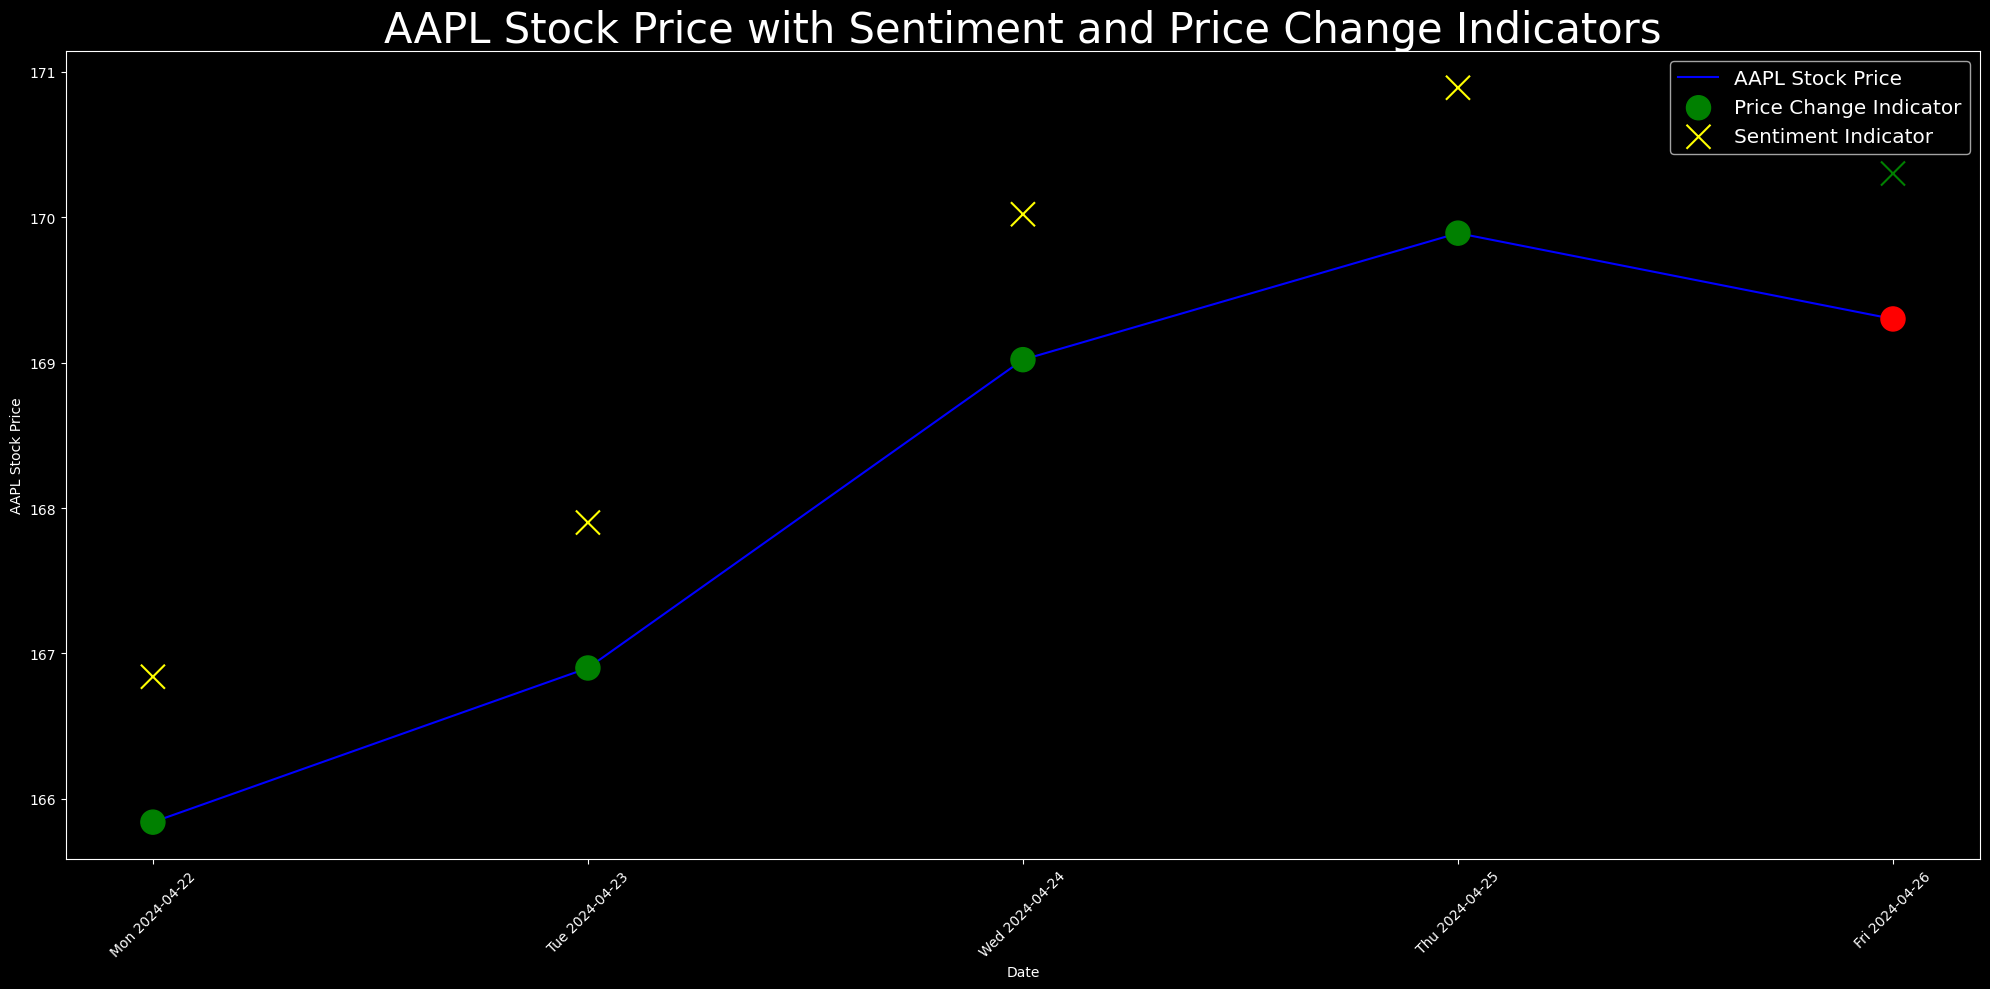

In [79]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.dates import DateFormatter, DayLocator

# Filter out weekends from the DataFrame
AAPL_df = AAPL_df[AAPL_df.index.dayofweek < 5]

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the AAPL stock prices for weekdays only
ax.plot(AAPL_df.index, AAPL_df['AAPL'], label='AAPL Stock Price', color='blue')

# Define the colors for the percentage change
percentage_change_colors = AAPL_df['AAPL_Percentage_Change'].apply(lambda x: 'green' if x > 0 else ('red' if x < 0 else 'yellow'))

# Scatter plot for the percentage change indicators with increased size
ax.scatter(AAPL_df.index, AAPL_df['AAPL'], color=percentage_change_colors, label='Price Change Indicator', s=300, zorder=5)

# Filter out the NaN values from 'Final_Sentiment' before plotting
sentiment_filtered_df = AAPL_df.dropna(subset=['Final_Sentiment'])

# Define the colors for the final sentiment
sentiment_colors = sentiment_filtered_df['Final_Sentiment'].apply(lambda x: 'green' if x > 0 else ('red' if x < 0 else 'yellow'))

# Scatter plot for the final sentiment indicators with a different symbol and increased size
ax.scatter(sentiment_filtered_df.index, sentiment_filtered_df['AAPL'] + 1, color=sentiment_colors, marker='x', label='Sentiment Indicator', s=300, zorder=5)

# Set the title and labels
ax.set_title('AAPL Stock Price with Sentiment and Price Change Indicators', fontsize=30)
ax.set_xlabel('Date')
ax.set_ylabel('AAPL Stock Price')

# Define the date format to include the weekday
date_form = DateFormatter("%a %Y-%m-%d")
ax.xaxis.set_major_formatter(date_form)

# Set the locator for the major ticks to a DayLocator to show every day
ax.xaxis.set_major_locator(DayLocator())

# Rotate and format the x-axis labels
plt.xticks(rotation=45)
plt.tight_layout()

# Add a legend with increased font size and marker scale
ax.legend(fontsize='x-large', markerscale=1)  # Adjust these values as needed

# make the theme dark for the plot
plt.style.use('dark_background')

# export the plot as a png
plt.savefig('/Users/shreyashgupta/Library/Mobile Documents/com~apple~CloudDocs/Github Projects/News_sentiment_correlation_project/Images/AAPL_stock_price_sentiment_price_change.png')

# Show the plot
plt.show()

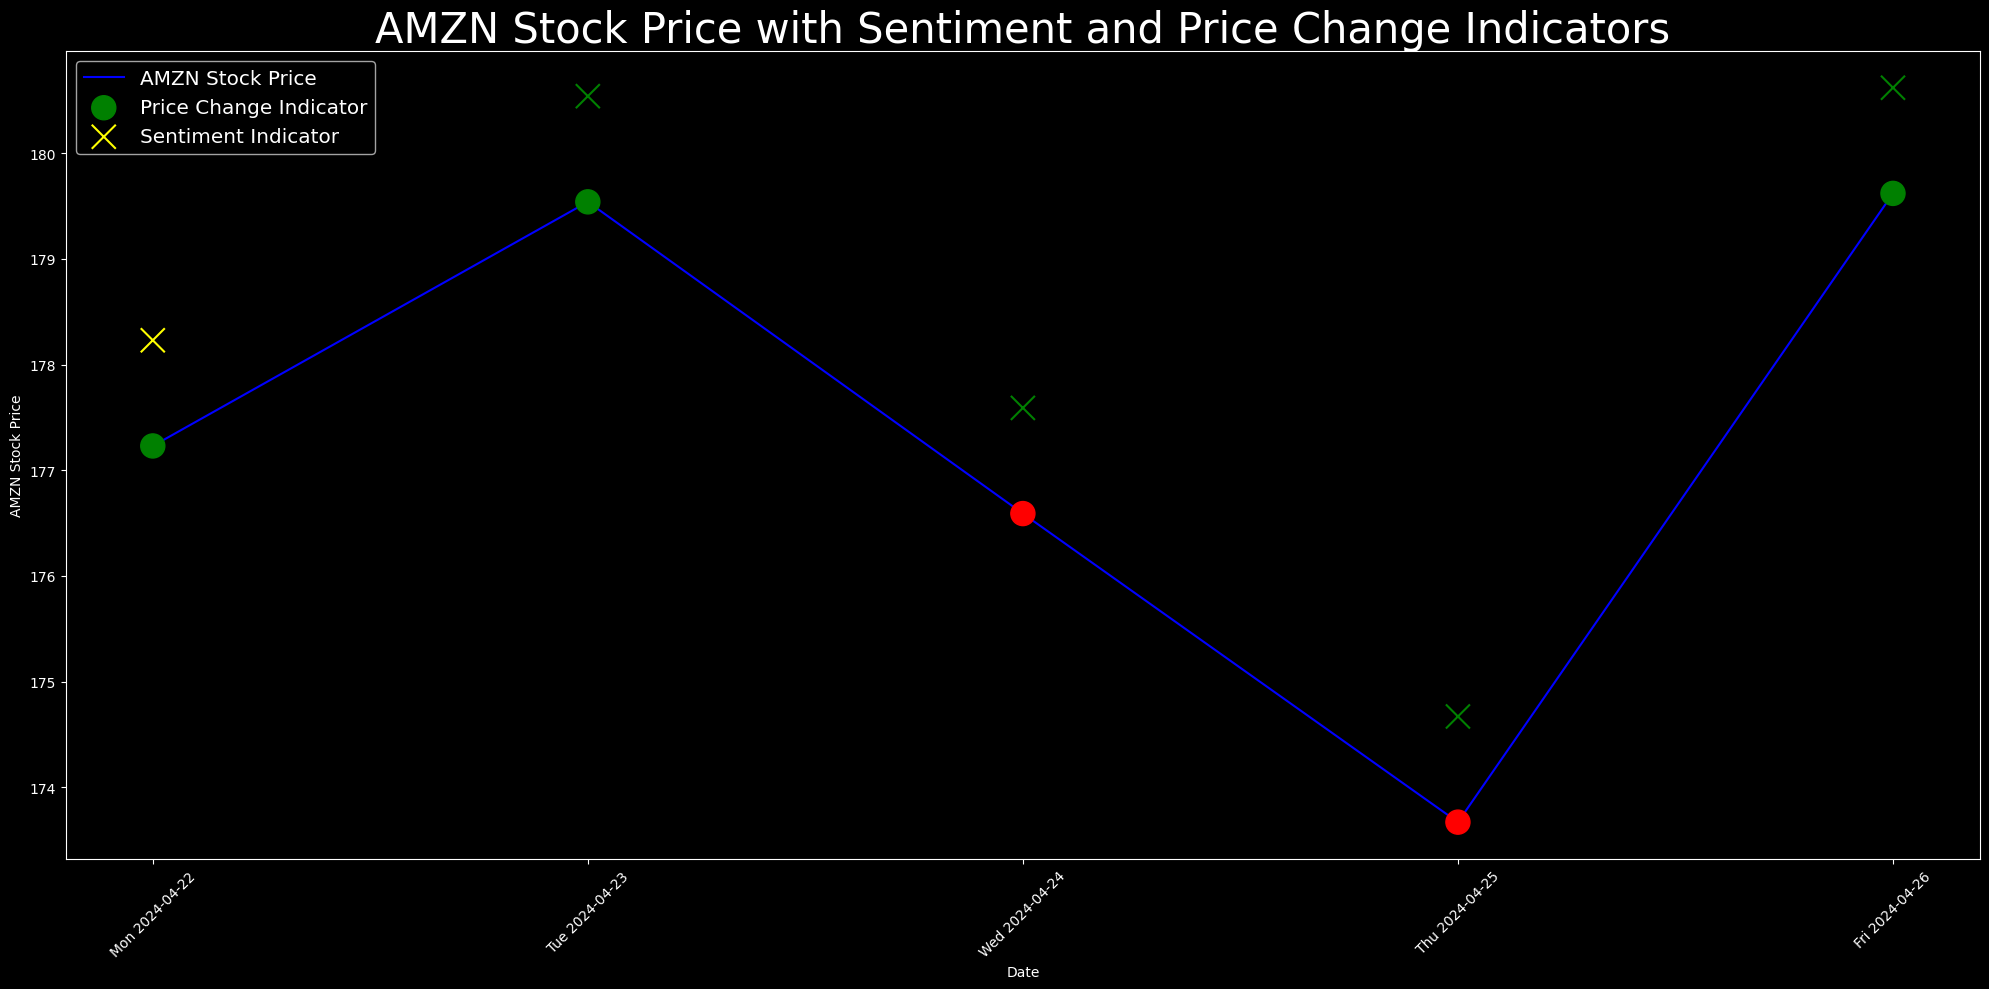

In [80]:
# Filter out weekends from the DataFrame
AMZN_df = AMZN_df[AMZN_df.index.dayofweek < 5]

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the AAPL stock prices for weekdays only
ax.plot(AMZN_df.index, AMZN_df['AMZN'], label='AMZN Stock Price', color='blue')

# Define the colors for the percentage change
percentage_change_colors = AMZN_df['AMZN_Percentage_Change'].apply(lambda x: 'green' if x > 0 else ('red' if x < 0 else 'yellow'))

# Scatter plot for the percentage change indicators with increased size
ax.scatter(AMZN_df.index, AMZN_df['AMZN'], color=percentage_change_colors, label='Price Change Indicator', s=300, zorder=5)

# Filter out the NaN values from 'Final_Sentiment' before plotting
sentiment_filtered_df = AMZN_df.dropna(subset=['Final_Sentiment'])

# Define the colors for the final sentiment
sentiment_colors = sentiment_filtered_df['Final_Sentiment'].apply(lambda x: 'green' if x > 0 else ('red' if x < 0 else 'yellow'))

# Scatter plot for the final sentiment indicators with a different symbol and increased size
ax.scatter(sentiment_filtered_df.index, sentiment_filtered_df['AMZN'] + 1, color=sentiment_colors, marker='x', label='Sentiment Indicator', s=300, zorder=5)

# Set the title and labels
ax.set_title('AMZN Stock Price with Sentiment and Price Change Indicators', fontsize=30)
ax.set_xlabel('Date')
ax.set_ylabel('AMZN Stock Price')

# Define the date format to include the weekday
date_form = DateFormatter("%a %Y-%m-%d")
ax.xaxis.set_major_formatter(date_form)

# Set the locator for the major ticks to a DayLocator to show every day
ax.xaxis.set_major_locator(DayLocator())

# Rotate and format the x-axis labels
plt.xticks(rotation=45)
plt.tight_layout()

# Add a legend with increased font size and marker scale
ax.legend(fontsize='x-large', markerscale=1)  # Adjust these values as needed

# make the theme dark for the plot
plt.style.use('dark_background')

plt.savefig('/Users/shreyashgupta/Library/Mobile Documents/com~apple~CloudDocs/Github Projects/News_sentiment_correlation_project/Images/AMZN_stock_price_sentiment_price_change.png')

# Show the plot
plt.show()

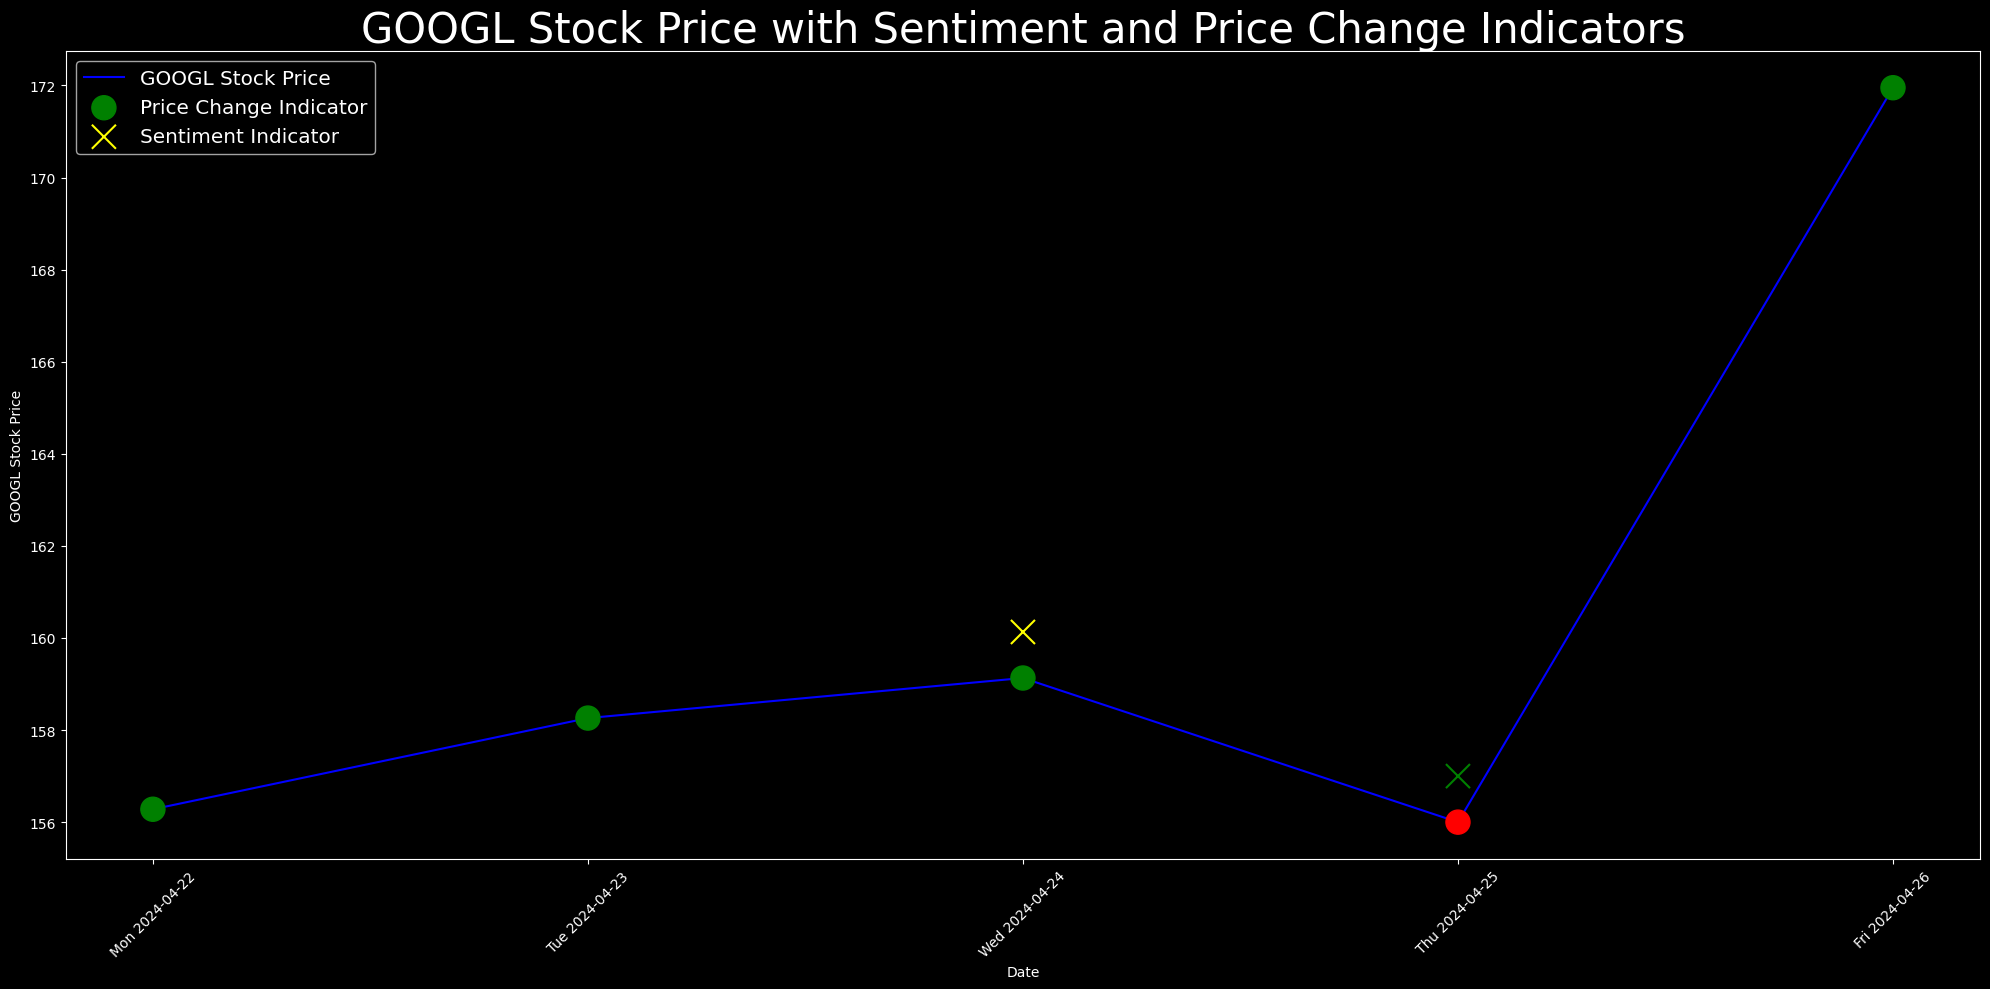

In [81]:
# Filter out weekends from the DataFrame
GOOGL_df = GOOGL_df[GOOGL_df.index.dayofweek < 5]

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the AAPL stock prices for weekdays only
ax.plot(GOOGL_df.index, GOOGL_df['GOOGL'], label='GOOGL Stock Price', color='blue')

# Define the colors for the percentage change
percentage_change_colors = GOOGL_df['GOOGL_Percentage_Change'].apply(lambda x: 'green' if x > 0 else ('red' if x < 0 else 'yellow'))

# Scatter plot for the percentage change indicators with increased size
ax.scatter(GOOGL_df.index, GOOGL_df['GOOGL'], color=percentage_change_colors, label='Price Change Indicator', s=300, zorder=5)

# Filter out the NaN values from 'Final_Sentiment' before plotting
sentiment_filtered_df = GOOGL_df.dropna(subset=['Final_Sentiment'])

# Define the colors for the final sentiment
sentiment_colors = sentiment_filtered_df['Final_Sentiment'].apply(lambda x: 'green' if x > 0 else ('red' if x < 0 else 'yellow'))

# Scatter plot for the final sentiment indicators with a different symbol and increased size
ax.scatter(sentiment_filtered_df.index, sentiment_filtered_df['GOOGL'] + 1, color=sentiment_colors, marker='x', label='Sentiment Indicator', s=300, zorder=5)

# Set the title and labels
ax.set_title('GOOGL Stock Price with Sentiment and Price Change Indicators', fontsize=30)
ax.set_xlabel('Date')
ax.set_ylabel('GOOGL Stock Price')

# Define the date format to include the weekday
date_form = DateFormatter("%a %Y-%m-%d")
ax.xaxis.set_major_formatter(date_form)

# Set the locator for the major ticks to a DayLocator to show every day
ax.xaxis.set_major_locator(DayLocator())

# Rotate and format the x-axis labels
plt.xticks(rotation=45)
plt.tight_layout()

# Add a legend with increased font size and marker scale
ax.legend(fontsize='x-large', markerscale=1)  # Adjust these values as needed

# make the theme dark for the plot
plt.style.use('dark_background')

plt.savefig('/Users/shreyashgupta/Library/Mobile Documents/com~apple~CloudDocs/Github Projects/News_sentiment_correlation_project/Images/GOOGL_stock_price_sentiment_price_change.png')

# Show the plot
plt.show()

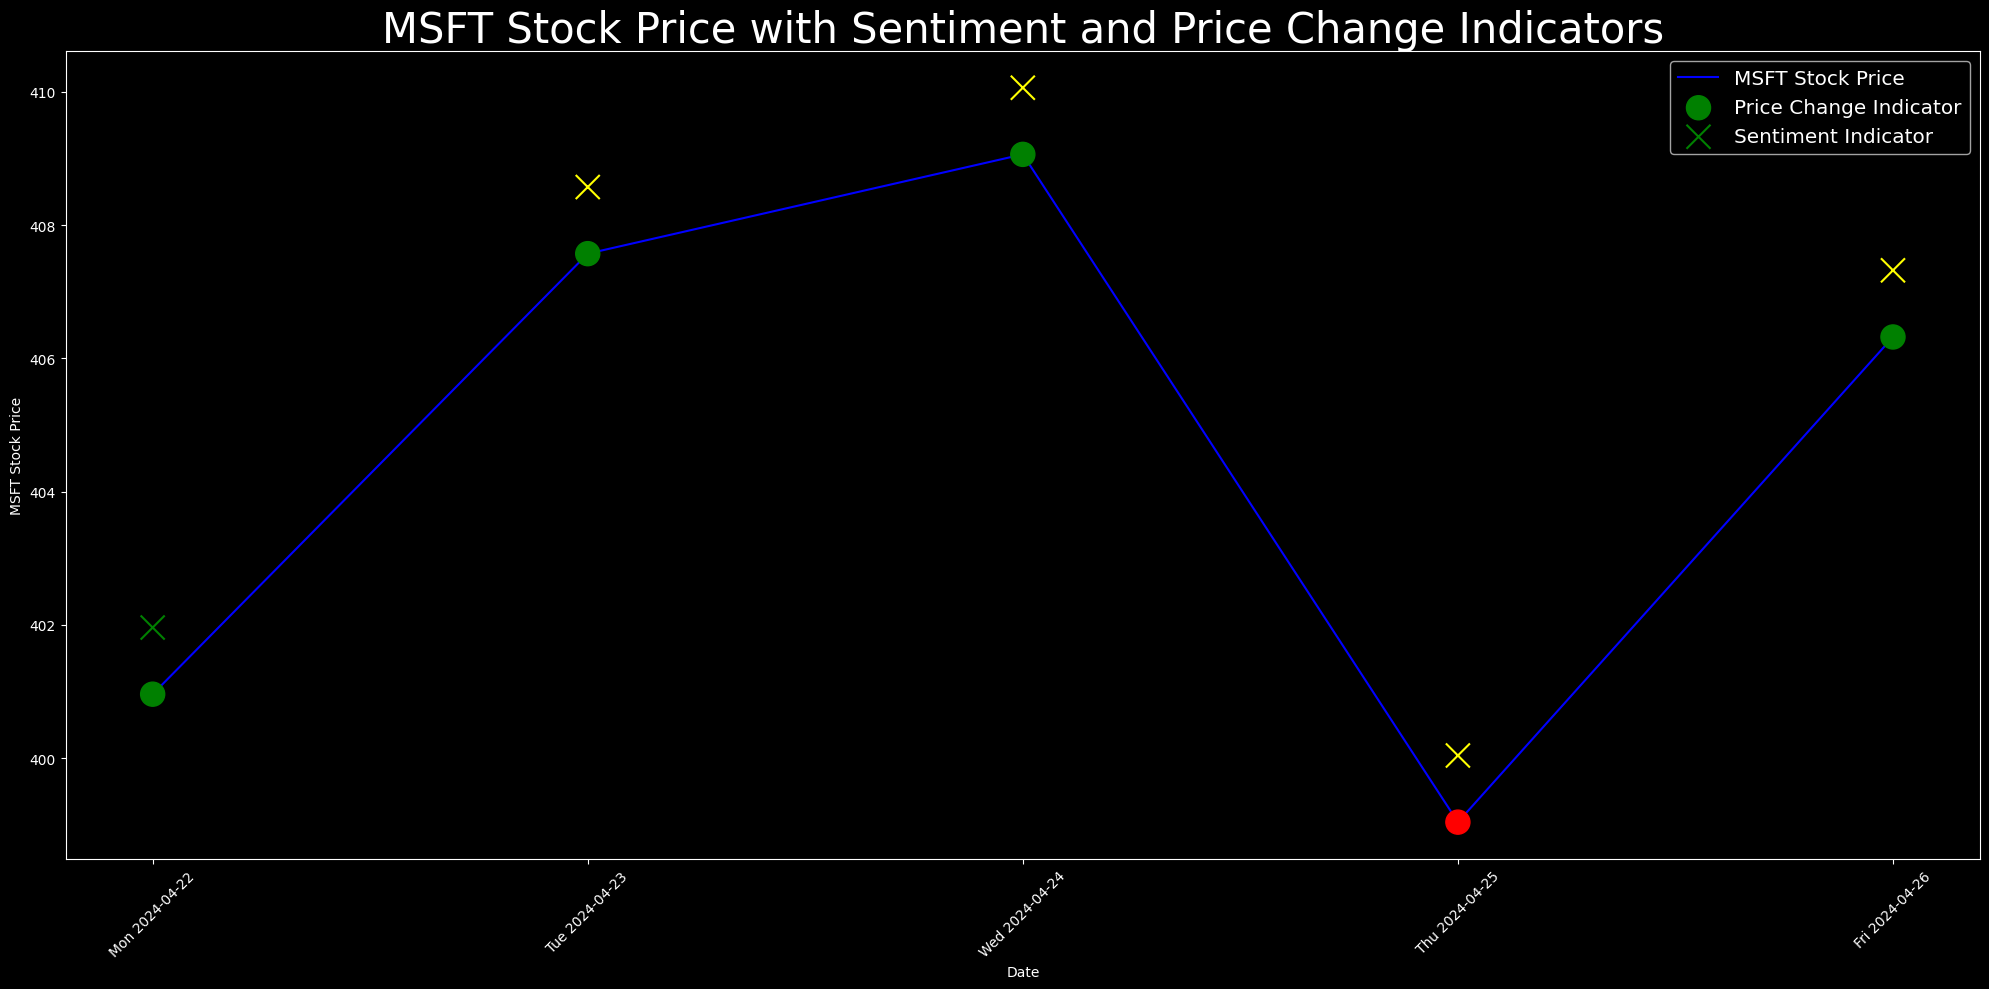

In [82]:
# Filter out weekends from the DataFrame
MSFT_df = MSFT_df[MSFT_df.index.dayofweek < 5]

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the AAPL stock prices for weekdays only
ax.plot(MSFT_df.index, MSFT_df['MSFT'], label='MSFT Stock Price', color='blue')

# Define the colors for the percentage change
percentage_change_colors = MSFT_df['MSFT_Percentage_Change'].apply(lambda x: 'green' if x > 0 else ('red' if x < 0 else 'yellow'))

# Scatter plot for the percentage change indicators with increased size
ax.scatter(MSFT_df.index, MSFT_df['MSFT'], color=percentage_change_colors, label='Price Change Indicator', s=300, zorder=5)

# Filter out the NaN values from 'Final_Sentiment' before plotting
sentiment_filtered_df = MSFT_df.dropna(subset=['Final_Sentiment'])

# Define the colors for the final sentiment
sentiment_colors = sentiment_filtered_df['Final_Sentiment'].apply(lambda x: 'green' if x > 0 else ('red' if x < 0 else 'yellow'))

# Scatter plot for the final sentiment indicators with a different symbol and increased size
ax.scatter(sentiment_filtered_df.index, sentiment_filtered_df['MSFT'] + 1, color=sentiment_colors, marker='x', label='Sentiment Indicator', s=300, zorder=5)

# Set the title and labels
ax.set_title('MSFT Stock Price with Sentiment and Price Change Indicators', fontsize=30)
ax.set_xlabel('Date')
ax.set_ylabel('MSFT Stock Price')

# Define the date format to include the weekday
date_form = DateFormatter("%a %Y-%m-%d")
ax.xaxis.set_major_formatter(date_form)

# Set the locator for the major ticks to a DayLocator to show every day
ax.xaxis.set_major_locator(DayLocator())

# Rotate and format the x-axis labels
plt.xticks(rotation=45)
plt.tight_layout()

# Add a legend with increased font size and marker scale
ax.legend(fontsize='x-large', markerscale=1)  # Adjust these values as needed

# make the theme dark for the plot
plt.style.use('dark_background')

plt.savefig('/Users/shreyashgupta/Library/Mobile Documents/com~apple~CloudDocs/Github Projects/News_sentiment_correlation_project/Images/MSFT_stock_price_sentiment_price_change.png')

# Show the plot
plt.show()

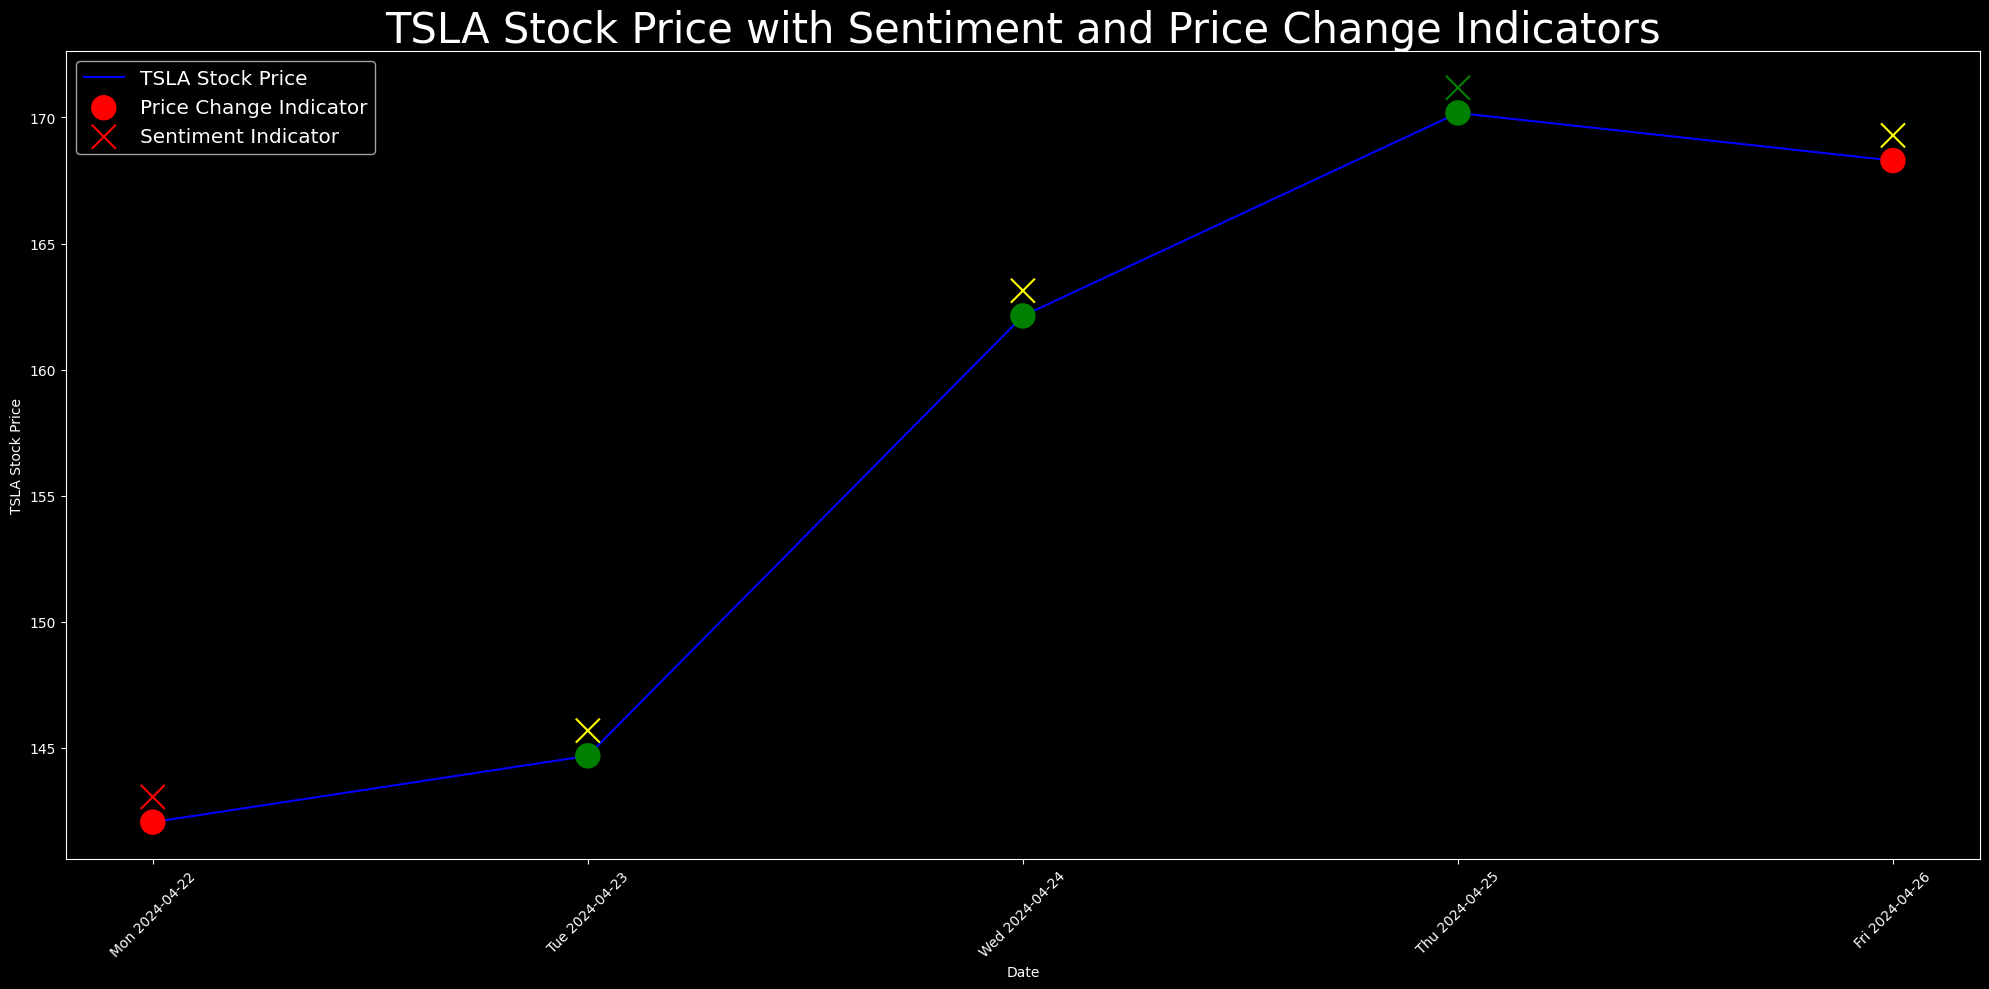

In [83]:
# Filter out weekends from the DataFrame
TSLA_df = TSLA_df[TSLA_df.index.dayofweek < 5]

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the AAPL stock prices for weekdays only
ax.plot(TSLA_df.index, TSLA_df['TSLA'], label='TSLA Stock Price', color='blue')

# Define the colors for the percentage change
percentage_change_colors = TSLA_df['TSLA_Percentage_Change'].apply(lambda x: 'green' if x > 0 else ('red' if x < 0 else 'yellow'))

# Scatter plot for the percentage change indicators with increased size
ax.scatter(TSLA_df.index, TSLA_df['TSLA'], color=percentage_change_colors, label='Price Change Indicator', s=300, zorder=5)

# Filter out the NaN values from 'Final_Sentiment' before plotting
sentiment_filtered_df = TSLA_df.dropna(subset=['Final_Sentiment'])

# Define the colors for the final sentiment
sentiment_colors = sentiment_filtered_df['Final_Sentiment'].apply(lambda x: 'green' if x > 0 else ('red' if x < 0 else 'yellow'))

# Scatter plot for the final sentiment indicators with a different symbol and increased size
ax.scatter(sentiment_filtered_df.index, sentiment_filtered_df['TSLA'] + 1, color=sentiment_colors, marker='x', label='Sentiment Indicator', s=300, zorder=5)

# Set the title and labels
ax.set_title('TSLA Stock Price with Sentiment and Price Change Indicators', fontsize=30)
ax.set_xlabel('Date')
ax.set_ylabel('TSLA Stock Price')

# Define the date format to include the weekday
date_form = DateFormatter("%a %Y-%m-%d")
ax.xaxis.set_major_formatter(date_form)

# Set the locator for the major ticks to a DayLocator to show every day
ax.xaxis.set_major_locator(DayLocator())

# Rotate and format the x-axis labels
plt.xticks(rotation=45)
plt.tight_layout()

# Add a legend with increased font size and marker scale
ax.legend(fontsize='x-large', markerscale=1)  # Adjust these values as needed

# make the theme dark for the plot
plt.style.use('dark_background')

plt.savefig('/Users/shreyashgupta/Library/Mobile Documents/com~apple~CloudDocs/Github Projects/News_sentiment_correlation_project/Images/TSLA_stock_price_sentiment_price_change.png')

# Show the plot
plt.show()

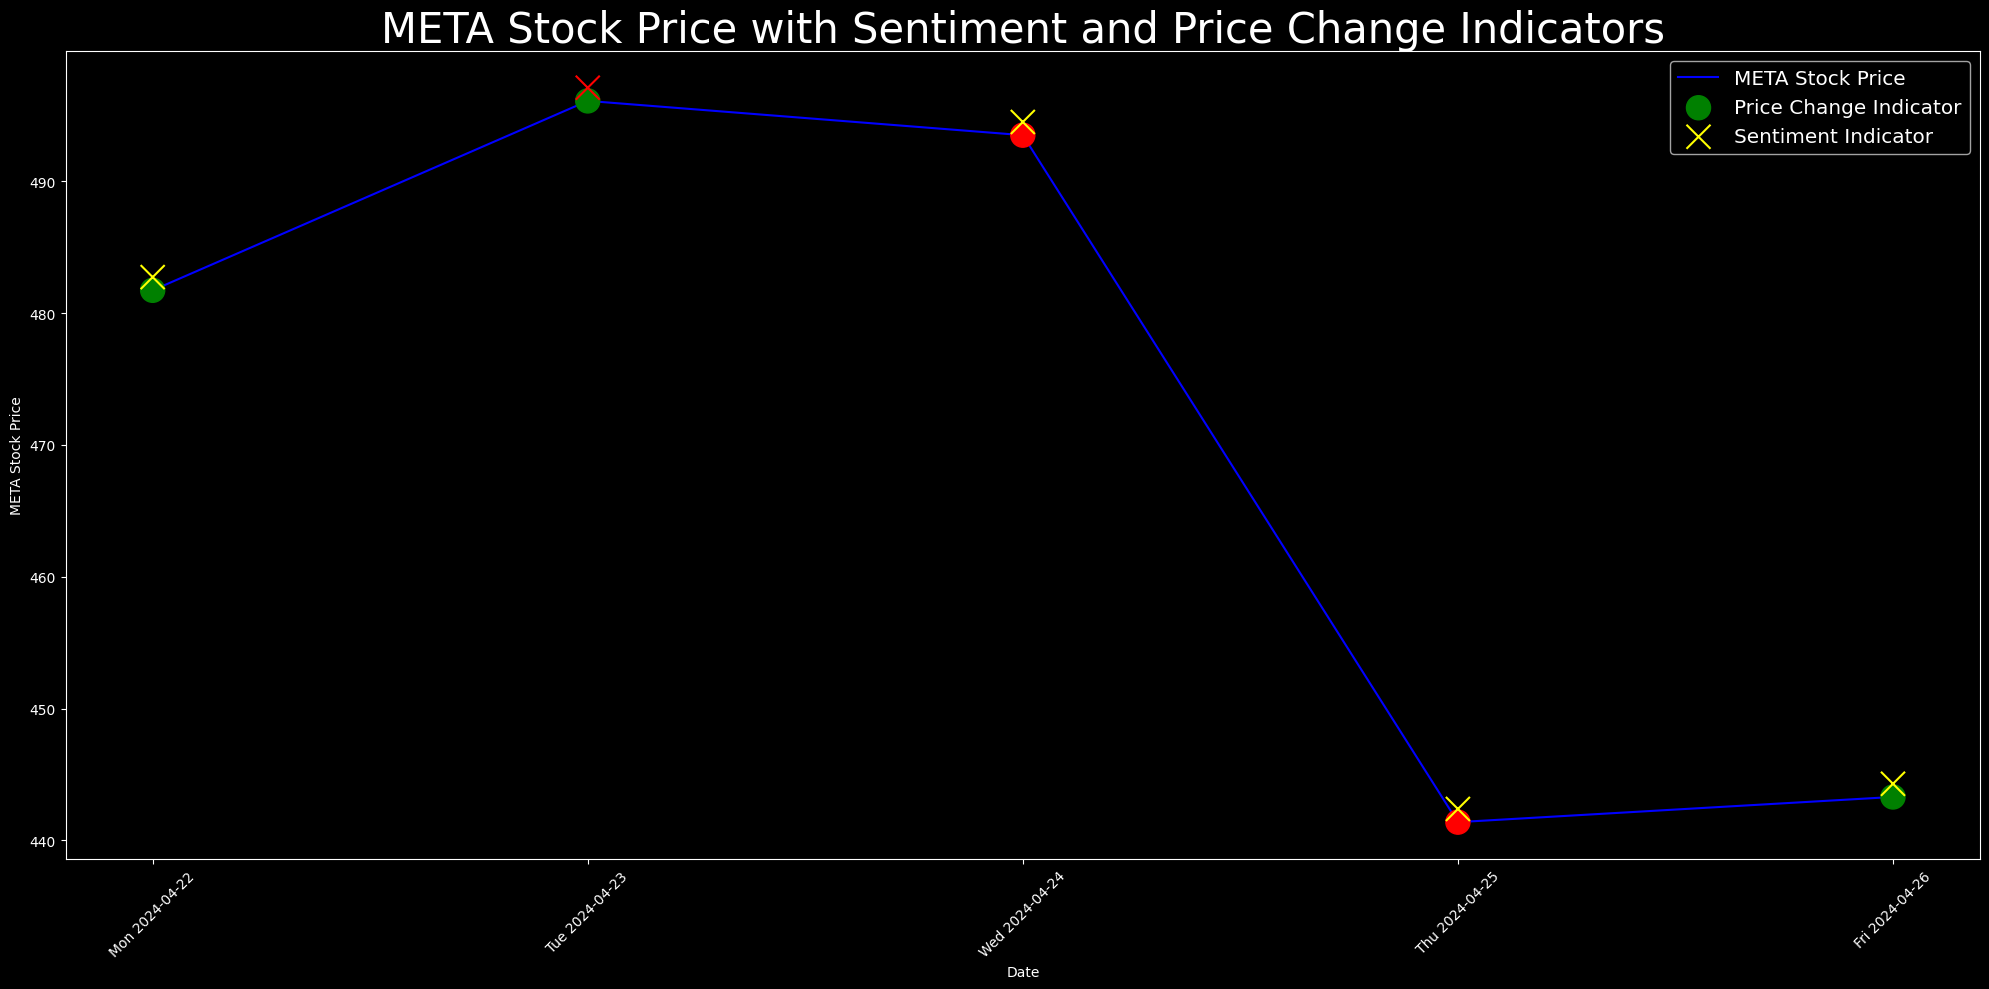

In [84]:
# Filter out weekends from the DataFrame
META_df = META_df[META_df.index.dayofweek < 5]

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the AAPL stock prices for weekdays only
ax.plot(META_df.index, META_df['META'], label='META Stock Price', color='blue')

# Define the colors for the percentage change
percentage_change_colors = META_df['META_Percentage_Change'].apply(lambda x: 'green' if x > 0 else ('red' if x < 0 else 'yellow'))

# Scatter plot for the percentage change indicators with increased size
ax.scatter(META_df.index, META_df['META'], color=percentage_change_colors, label='Price Change Indicator', s=300, zorder=5)

# Filter out the NaN values from 'Final_Sentiment' before plotting
sentiment_filtered_df = META_df.dropna(subset=['Final_Sentiment'])

# Define the colors for the final sentiment
sentiment_colors = sentiment_filtered_df['Final_Sentiment'].apply(lambda x: 'green' if x > 0 else ('red' if x < 0 else 'yellow'))

# Scatter plot for the final sentiment indicators with a different symbol and increased size
ax.scatter(sentiment_filtered_df.index, sentiment_filtered_df['META'] + 1, color=sentiment_colors, marker='x', label='Sentiment Indicator', s=300, zorder=5)

# Set the title and labels
ax.set_title('META Stock Price with Sentiment and Price Change Indicators', fontsize=30)
ax.set_xlabel('Date')
ax.set_ylabel('META Stock Price')

# Define the date format to include the weekday
date_form = DateFormatter("%a %Y-%m-%d")
ax.xaxis.set_major_formatter(date_form)

# Set the locator for the major ticks to a DayLocator to show every day
ax.xaxis.set_major_locator(DayLocator())

# Rotate and format the x-axis labels
plt.xticks(rotation=45)
plt.tight_layout()

# Add a legend with increased font size and marker scale
ax.legend(fontsize='x-large', markerscale=1)  # Adjust these values as needed

# make the theme dark for the plot
plt.style.use('dark_background')

plt.savefig('/Users/shreyashgupta/Library/Mobile Documents/com~apple~CloudDocs/Github Projects/News_sentiment_correlation_project/Images/META_stock_price_sentiment_price_change.png')

# Show the plot
plt.show()

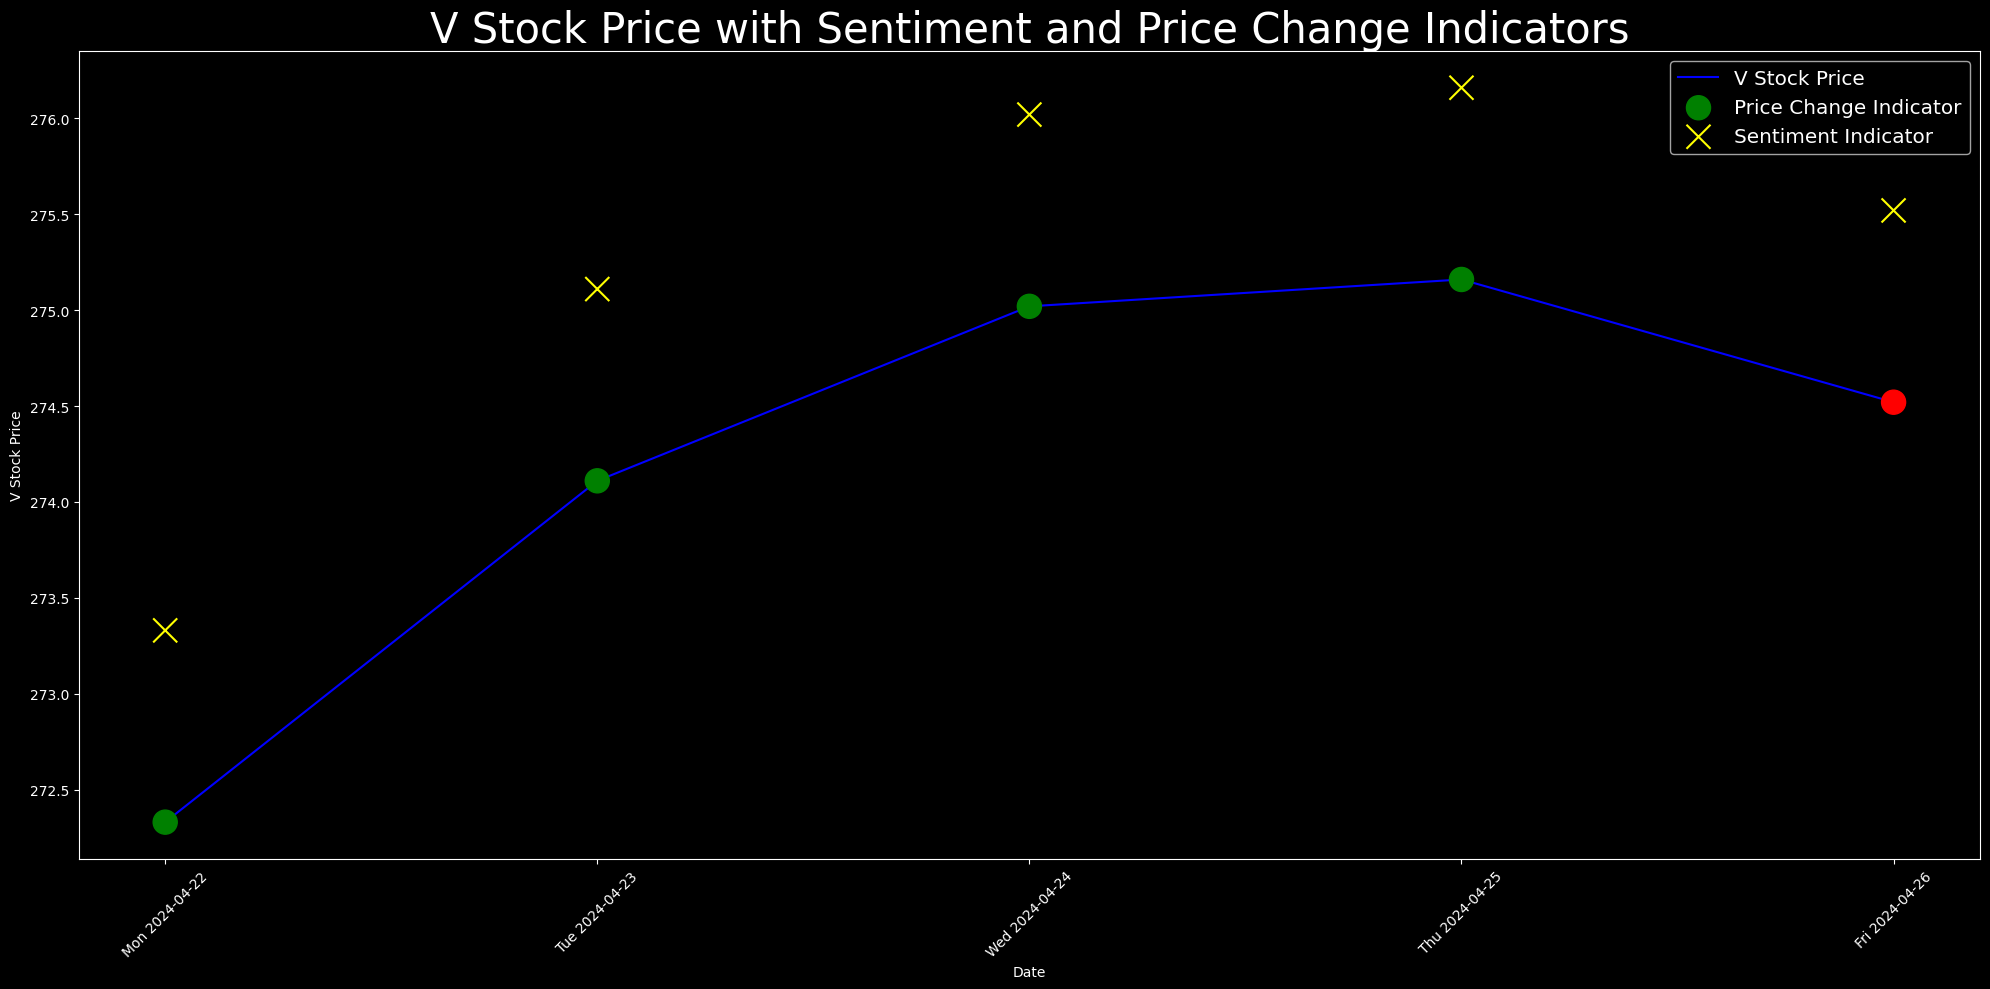

In [85]:
# Filter out weekends from the DataFrame
V_df = V_df[V_df.index.dayofweek < 5]

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the AAPL stock prices for weekdays only
ax.plot(V_df.index, V_df['V'], label='V Stock Price', color='blue')

# Define the colors for the percentage change
percentage_change_colors = V_df['V_Percentage_Change'].apply(lambda x: 'green' if x > 0 else ('red' if x < 0 else 'yellow'))

# Scatter plot for the percentage change indicators with increased size
ax.scatter(V_df.index, V_df['V'], color=percentage_change_colors, label='Price Change Indicator', s=300, zorder=5)

# Filter out the NaN values from 'Final_Sentiment' before plotting
sentiment_filtered_df = V_df.dropna(subset=['Final_Sentiment'])

# Define the colors for the final sentiment
sentiment_colors = sentiment_filtered_df['Final_Sentiment'].apply(lambda x: 'green' if x > 0 else ('red' if x < 0 else 'yellow'))

# Scatter plot for the final sentiment indicators with a different symbol and increased size
ax.scatter(sentiment_filtered_df.index, sentiment_filtered_df['V'] + 1, color=sentiment_colors, marker='x', label='Sentiment Indicator', s=300, zorder=5)

# Set the title and labels
ax.set_title('V Stock Price with Sentiment and Price Change Indicators', fontsize=30)
ax.set_xlabel('Date')
ax.set_ylabel('V Stock Price')

# Define the date format to include the weekday
date_form = DateFormatter("%a %Y-%m-%d")
ax.xaxis.set_major_formatter(date_form)

# Set the locator for the major ticks to a DayLocator to show every day
ax.xaxis.set_major_locator(DayLocator())

# Rotate and format the x-axis labels
plt.xticks(rotation=45)
plt.tight_layout()

# Add a legend with increased font size and marker scale
ax.legend(fontsize='x-large', markerscale=1)  # Adjust these values as needed

# make the theme dark for the plot
plt.style.use('dark_background')

plt.savefig('/Users/shreyashgupta/Library/Mobile Documents/com~apple~CloudDocs/Github Projects/News_sentiment_correlation_project/Images/V_stock_price_sentiment_price_change.png')

# Show the plot
plt.show()

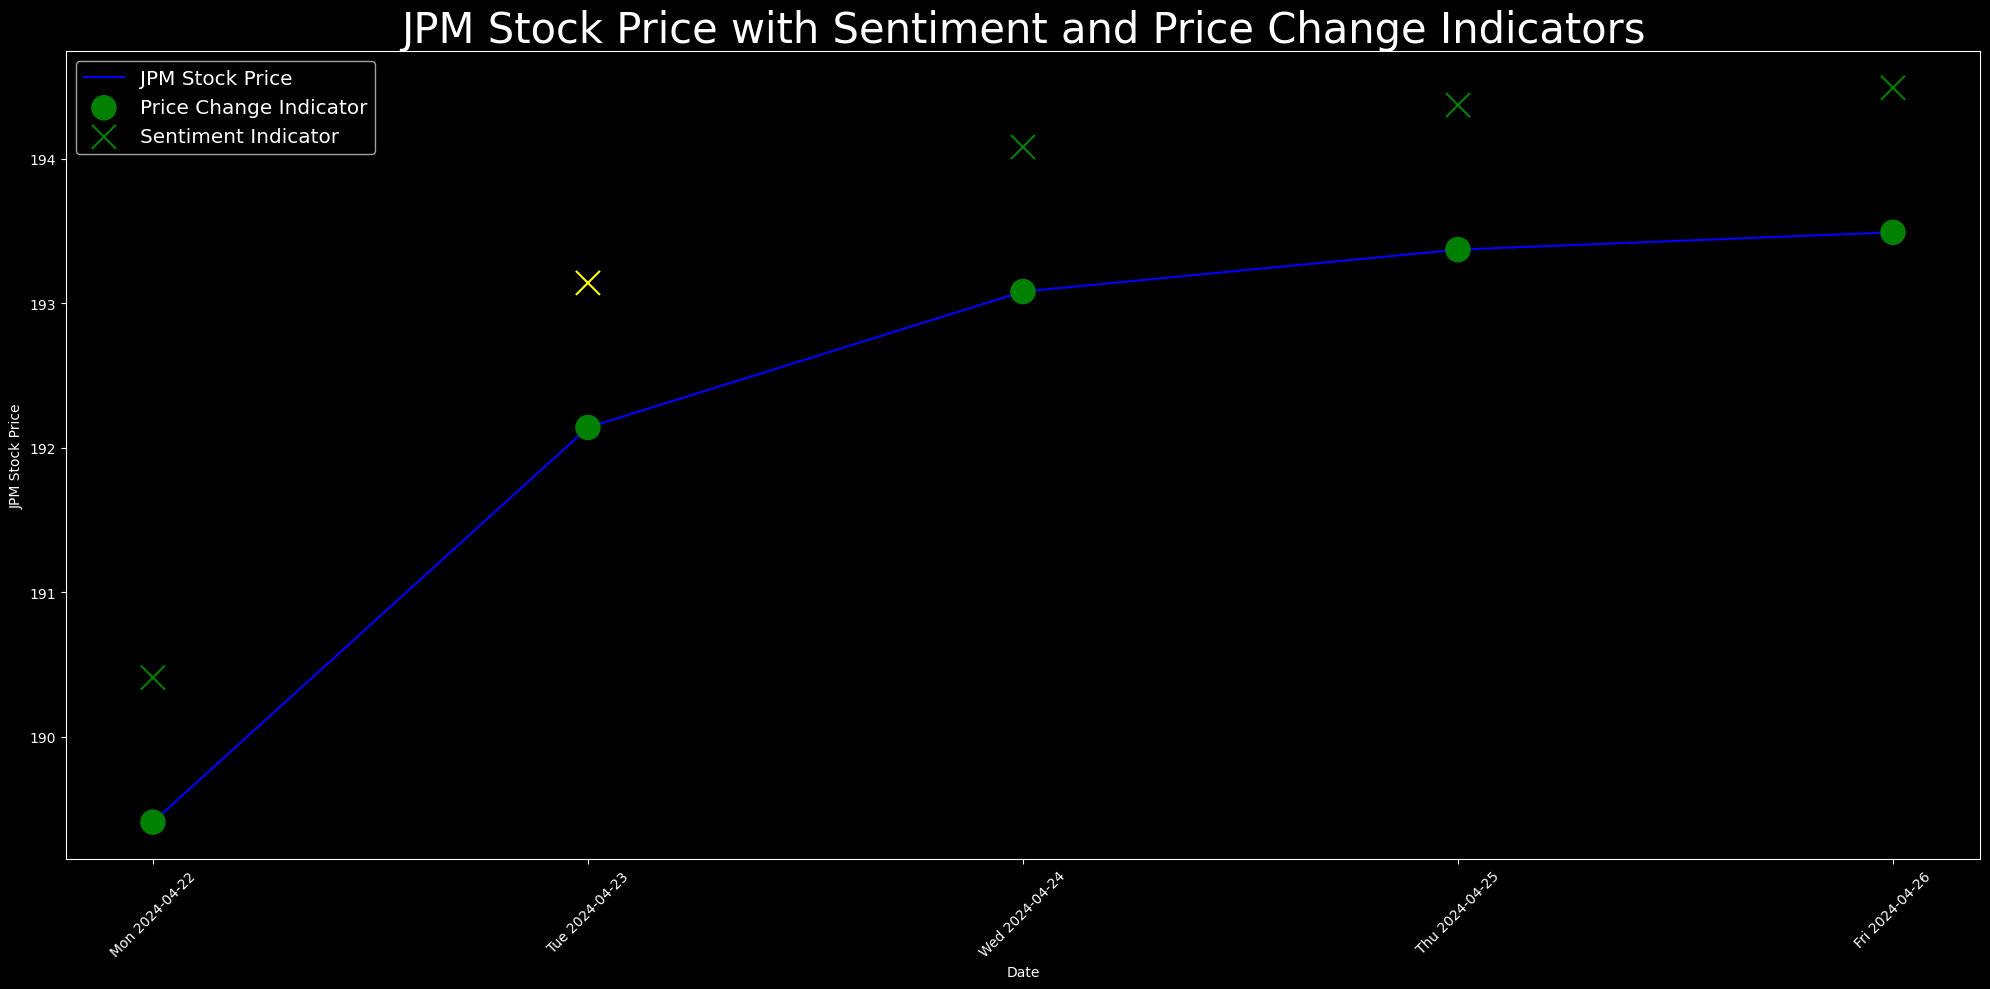

In [86]:
# Filter out weekends from the DataFrame
JPM_df = JPM_df[JPM_df.index.dayofweek < 5]

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the AAPL stock prices for weekdays only
ax.plot(JPM_df.index, JPM_df['JPM'], label='JPM Stock Price', color='blue')

# Define the colors for the percentage change
percentage_change_colors = JPM_df['JPM_Percentage_Change'].apply(lambda x: 'green' if x > 0 else ('red' if x < 0 else 'yellow'))

# Scatter plot for the percentage change indicators with increased size
ax.scatter(JPM_df.index, JPM_df['JPM'], color=percentage_change_colors, label='Price Change Indicator', s=300, zorder=5)

# Filter out the NaN JPMalues from 'Final_Sentiment' before plotting
sentiment_filtered_df = JPM_df.dropna(subset=['Final_Sentiment'])

# Define the colors for the final sentiment
sentiment_colors = sentiment_filtered_df['Final_Sentiment'].apply(lambda x: 'green' if x > 0 else ('red' if x < 0 else 'yellow'))

# Scatter plot for the final sentiment indicators with a different symbol and increased size
ax.scatter(sentiment_filtered_df.index, sentiment_filtered_df['JPM'] + 1, color=sentiment_colors, marker='x', label='Sentiment Indicator', s=300, zorder=5)

# Set the title and labels
ax.set_title('JPM Stock Price with Sentiment and Price Change Indicators', fontsize=30)
ax.set_xlabel('Date')
ax.set_ylabel('JPM Stock Price')

# Define the date format to include the weekday
date_form = DateFormatter("%a %Y-%m-%d")
ax.xaxis.set_major_formatter(date_form)

# Set the locator for the major ticks to a DayLocator to show eJPMery day
ax.xaxis.set_major_locator(DayLocator())

# Rotate and format the x-axis labels
plt.xticks(rotation=45)
plt.tight_layout()

# Add a legend with increased font size and marker scale
ax.legend(fontsize='x-large', markerscale=1)  # Adjust these JPMalues as needed

# make the theme dark for the plot
plt.style.use('dark_background')

plt.savefig('/Users/shreyashgupta/Library/Mobile Documents/com~apple~CloudDocs/Github Projects/News_sentiment_correlation_project/Images/JPM_stock_price_sentiment_price_change.png')

# Show the plot
plt.show()

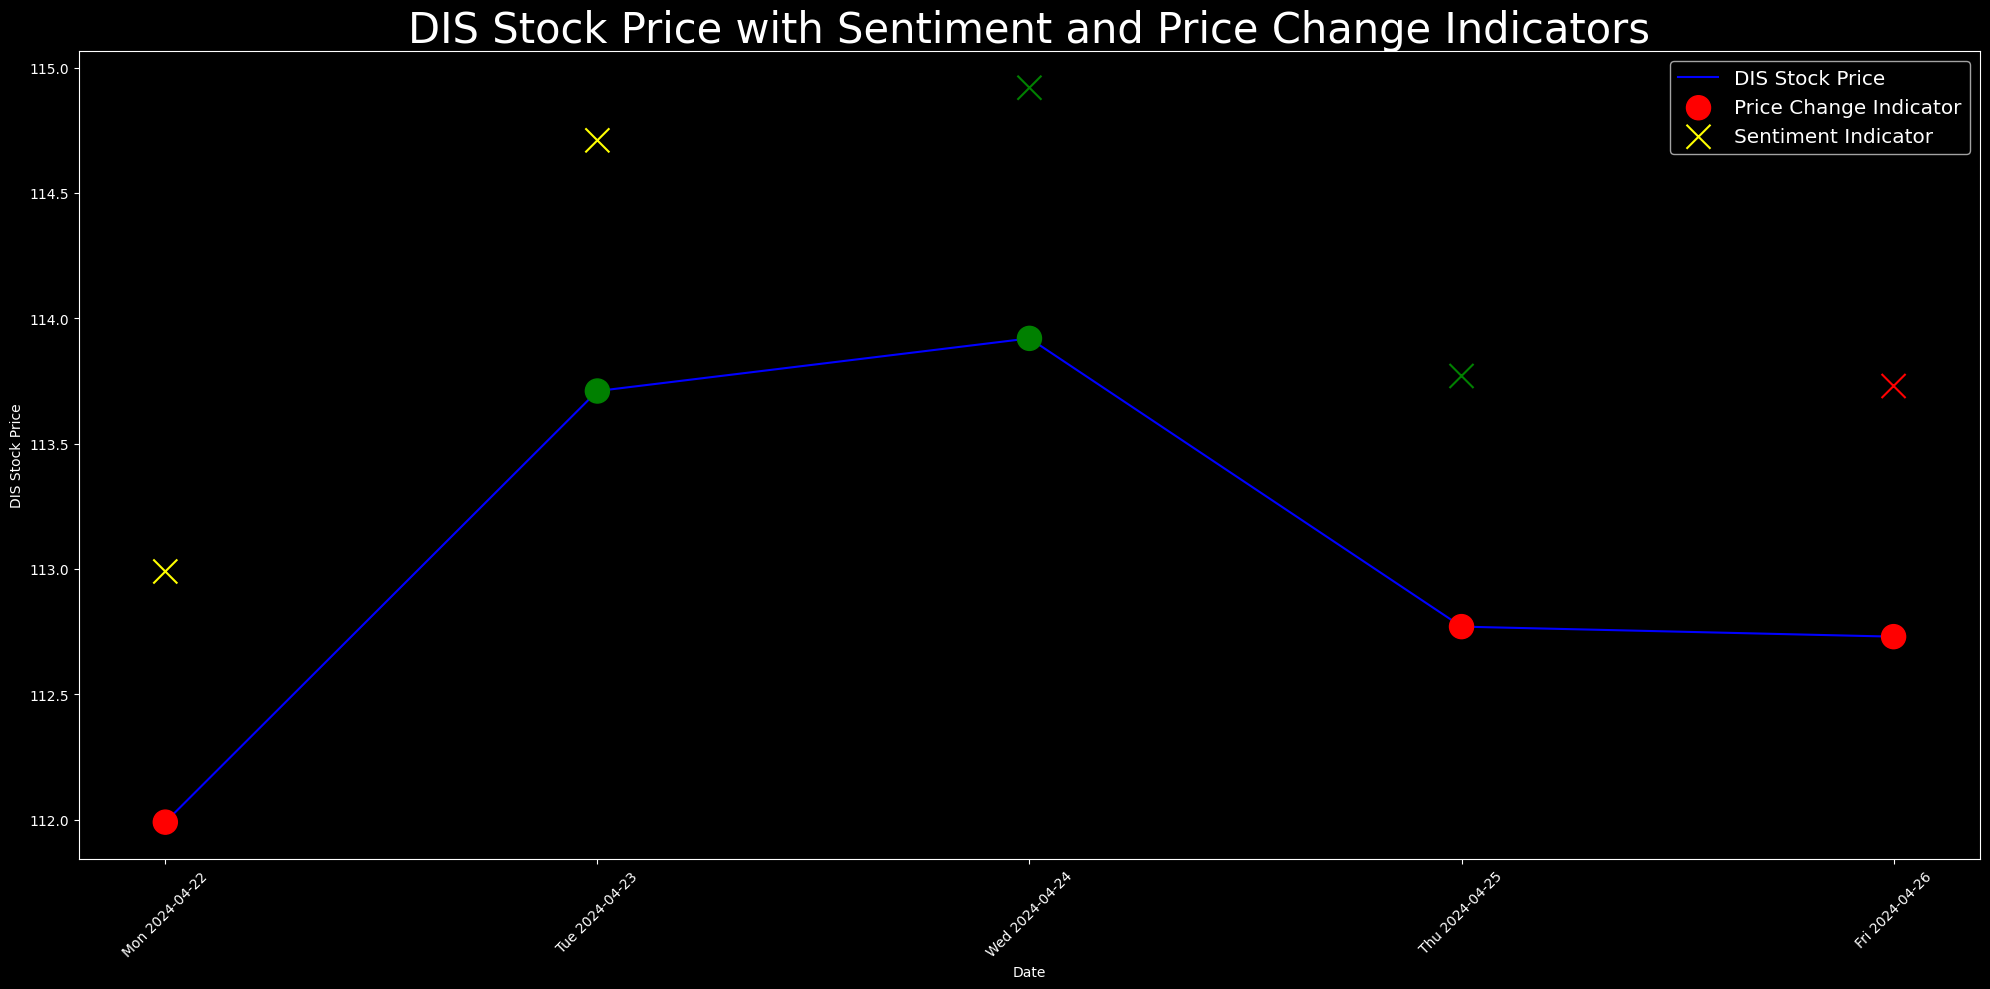

In [87]:
# Filter out weekends from the DataFrame
DIS_df = DIS_df[DIS_df.index.dayofweek < 5]

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the AAPL stock prices for weekdays only
ax.plot(DIS_df.index, DIS_df['DIS'], label='DIS Stock Price', color='blue')

# Define the colors for the percentage change
percentage_change_colors = DIS_df['DIS_Percentage_Change'].apply(lambda x: 'green' if x > 0 else ('red' if x < 0 else 'yellow'))

# Scatter plot for the percentage change indicators with increased size
ax.scatter(DIS_df.index, DIS_df['DIS'], color=percentage_change_colors, label='Price Change Indicator', s=300, zorder=5)

# Filter out the NaN DISalues from 'Final_Sentiment' before plotting
sentiment_filtered_df = DIS_df.dropna(subset=['Final_Sentiment'])

# Define the colors for the final sentiment
sentiment_colors = sentiment_filtered_df['Final_Sentiment'].apply(lambda x: 'green' if x > 0 else ('red' if x < 0 else 'yellow'))

# Scatter plot for the final sentiment indicators with a different symbol and increased size
ax.scatter(sentiment_filtered_df.index, sentiment_filtered_df['DIS'] + 1, color=sentiment_colors, marker='x', label='Sentiment Indicator', s=300, zorder=5)

# Set the title and labels
ax.set_title('DIS Stock Price with Sentiment and Price Change Indicators', fontsize=30)
ax.set_xlabel('Date')
ax.set_ylabel('DIS Stock Price')

# Define the date format to include the weekday
date_form = DateFormatter("%a %Y-%m-%d")
ax.xaxis.set_major_formatter(date_form)

# Set the locator for the major ticks to a DayLocator to show eDISery day
ax.xaxis.set_major_locator(DayLocator())

# Rotate and format the x-axis labels
plt.xticks(rotation=45)
plt.tight_layout()

# Add a legend with increased font size and marker scale
ax.legend(fontsize='x-large', markerscale=1)  # Adjust these DISalues as needed

# make the theme dark for the plot
plt.style.use('dark_background')

plt.savefig('/Users/shreyashgupta/Library/Mobile Documents/com~apple~CloudDocs/Github Projects/News_sentiment_correlation_project/Images/DIS_stock_price_sentiment_price_change.png')

# Show the plot
plt.show()

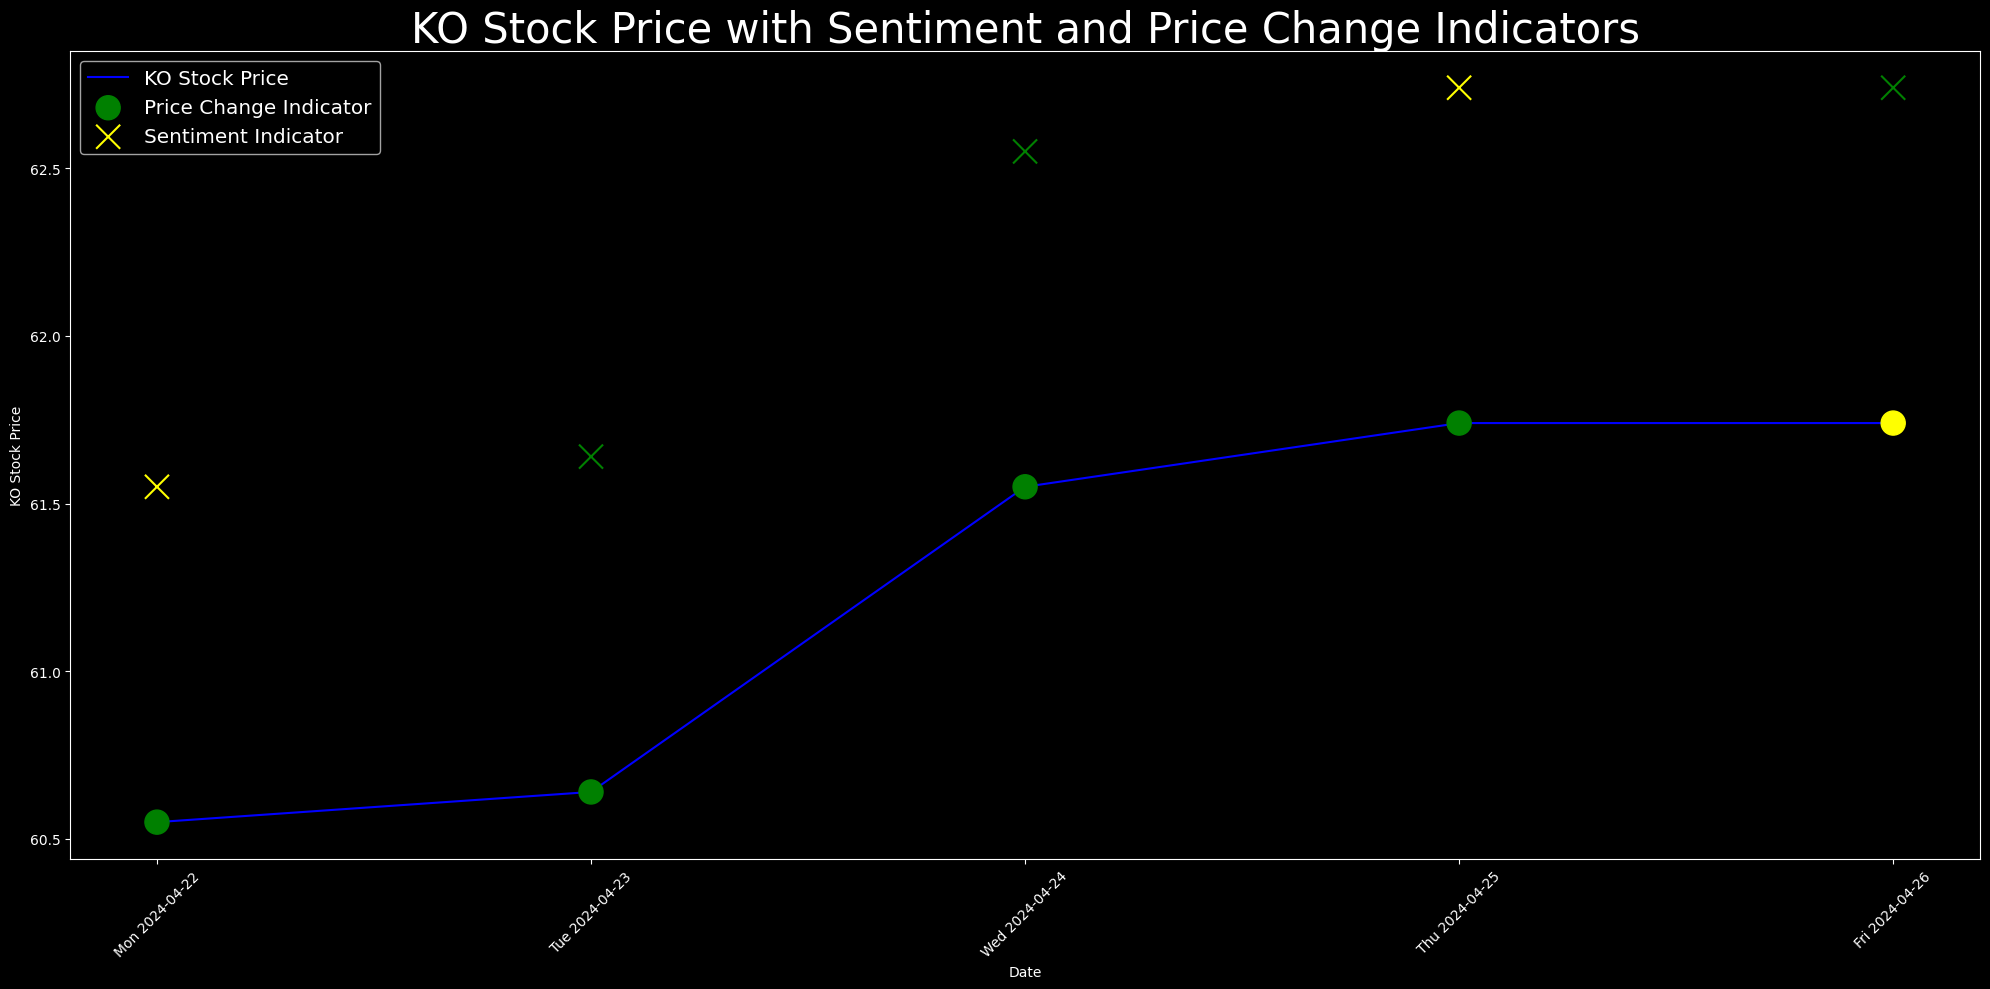

In [88]:
# Filter out weekends from the DataFrame
KO_df = KO_df[KO_df.index.dayofweek < 5]

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the AAPL stock prices for weekdays only
ax.plot(KO_df.index, KO_df['KO'], label='KO Stock Price', color='blue')

# Define the colors for the percentage change
percentage_change_colors = KO_df['KO_Percentage_Change'].apply(lambda x: 'green' if x > 0 else ('red' if x < 0 else 'yellow'))

# Scatter plot for the percentage change indicators with increased size
ax.scatter(KO_df.index, KO_df['KO'], color=percentage_change_colors, label='Price Change Indicator', s=300, zorder=5)

# Filter out the NaN KOalues from 'Final_Sentiment' before plotting
sentiment_filtered_df = KO_df.dropna(subset=['Final_Sentiment'])

# Define the colors for the final sentiment
sentiment_colors = sentiment_filtered_df['Final_Sentiment'].apply(lambda x: 'green' if x > 0 else ('red' if x < 0 else 'yellow'))

# Scatter plot for the final sentiment indicators with a different symbol and increased size
ax.scatter(sentiment_filtered_df.index, sentiment_filtered_df['KO'] + 1, color=sentiment_colors, marker='x', label='Sentiment Indicator', s=300, zorder=5)

# Set the title and labels
ax.set_title('KO Stock Price with Sentiment and Price Change Indicators', fontsize=30)
ax.set_xlabel('Date')
ax.set_ylabel('KO Stock Price')

# Define the date format to include the weekday
date_form = DateFormatter("%a %Y-%m-%d")
ax.xaxis.set_major_formatter(date_form)

# Set the locator for the major ticks to a DayLocator to show eKOery day
ax.xaxis.set_major_locator(DayLocator())

# Rotate and format the x-axis labels
plt.xticks(rotation=45)
plt.tight_layout()

# Add a legend with increased font size and marker scale
ax.legend(fontsize='x-large', markerscale=1)  # Adjust these KOalues as needed

# make the theme dark for the plot
plt.style.use('dark_background')

plt.savefig('/Users/shreyashgupta/Library/Mobile Documents/com~apple~CloudDocs/Github Projects/News_sentiment_correlation_project/Images/KO_stock_price_sentiment_price_change.png')

# Show the plot
plt.show()

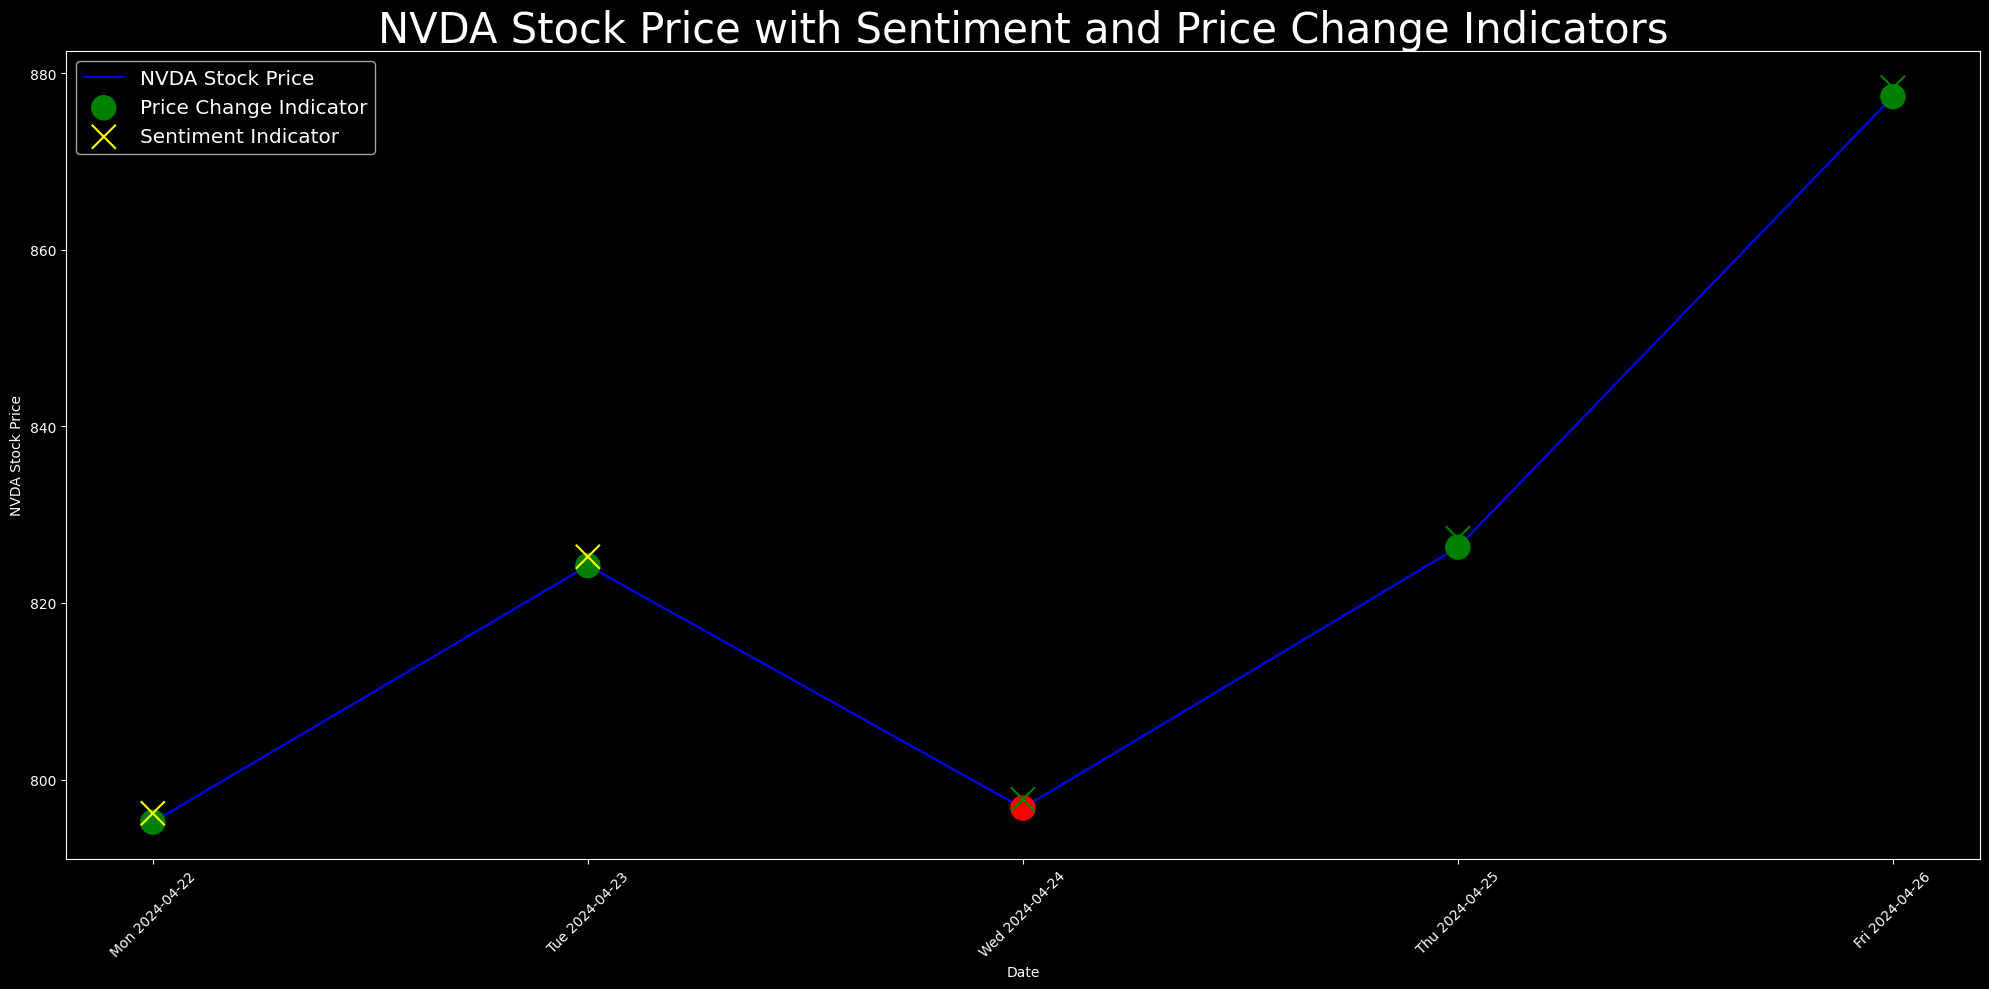

In [89]:
# Filter out weekends from the DataFrame
NVDA_df = NVDA_df[NVDA_df.index.dayofweek < 5]

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the AAPL stock prices for weekdays only
ax.plot(NVDA_df.index, NVDA_df['NVDA'], label='NVDA Stock Price', color='blue')

# Define the colors for the percentage change
percentage_change_colors = NVDA_df['NVDA_Percentage_Change'].apply(lambda x: 'green' if x > 0 else ('red' if x < 0 else 'yellow'))

# Scatter plot for the percentage change indicators with increased size
ax.scatter(NVDA_df.index, NVDA_df['NVDA'], color=percentage_change_colors, label='Price Change Indicator', s=300, zorder=5)

# Filter out the NaN NVDAalues from 'Final_Sentiment' before plotting
sentiment_filtered_df = NVDA_df.dropna(subset=['Final_Sentiment'])

# Define the colors for the final sentiment
sentiment_colors = sentiment_filtered_df['Final_Sentiment'].apply(lambda x: 'green' if x > 0 else ('red' if x < 0 else 'yellow'))

# Scatter plot for the final sentiment indicators with a different symbol and increased size
ax.scatter(sentiment_filtered_df.index, sentiment_filtered_df['NVDA'] + 1, color=sentiment_colors, marker='x', label='Sentiment Indicator', s=300, zorder=5)

# Set the title and labels
ax.set_title('NVDA Stock Price with Sentiment and Price Change Indicators', fontsize=30)
ax.set_xlabel('Date')
ax.set_ylabel('NVDA Stock Price')

# Define the date format to include the weekday
date_form = DateFormatter("%a %Y-%m-%d")
ax.xaxis.set_major_formatter(date_form)

# Set the locator for the major ticks to a DayLocator to show eNVDAery day
ax.xaxis.set_major_locator(DayLocator())

# Rotate and format the x-axis labels
plt.xticks(rotation=45)
plt.tight_layout()

# Add a legend with increased font size and marker scale
ax.legend(fontsize='x-large', markerscale=1)  # Adjust these NVDAalues as needed

# make the theme dark for the plot
plt.style.use('dark_background')

plt.savefig('/Users/shreyashgupta/Library/Mobile Documents/com~apple~CloudDocs/Github Projects/News_sentiment_correlation_project/Images/NVDA_stock_price_sentiment_price_change.png')

# Show the plot
plt.show()